## Senior Thesis Chapter 3 Code
#### Justin Kaashoek

This notebook is structured in the following way:

(1) Importing packages

(2) Compiling and Cleaning Data

(3) Calculating Death Rates

(4) Descriptive Analysis

(5) Regressions

(6) Mapping

### Section 1: Packages

In [5]:
# Numpy, pandas, and scipy
import numpy as np
import pandas as pd
import scipy

# Sklearn packages for modeling
from collections import OrderedDict
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression, Lasso
from sklearn.model_selection import RepeatedKFold, train_test_split, RandomizedSearchCV
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from statsmodels.tools import add_constant

# Spatial packages
import geopandas as gpd
import libpysal
from shapely.geometry import Point
from esda.moran import Moran
from splot.esda import moran_scatterplot, plot_moran
from spreg import ML_Lag

# Plotting packages
import seaborn as sns
from matplotlib import font_manager as fm, rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable, inset_locator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import networkx as nx

# Other data and math packages
import os
import censusdata
import requests
import covidcast
from math import *

In [6]:
## Constants

# Number of days to use in linear smoothing
SMOOTH = 7
# Requirement for county to be considered seeded
DEATH_CUTOFF = 5
# Requirement for a county's population (currently including all counties)
POPULATION_CUTOFF = 0

In [7]:
# Point to font file: I had problems switching fonts so decided to provide a helvetic ttf file instead
# Font file was found using Google fonts
fpath = os.path.join(rcParams["datapath"], "fonts/ttf/Helvetica.ttf")
prop = fm.FontProperties(fname=fpath)

In [8]:
# Mapping from states to abbreviations and vice versa

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

### Section 2: Compiling Data

We'll start with cumulative death counts 

In [11]:
# Read in John's Hopkins data (both deaths and cases)

county_cases = pd.read_csv("../data/time_series_covid19_confirmed_US.csv")
county_deaths = pd.read_csv("../data/time_series_covid19_deaths_US.csv")


print("Number of rows:", len(county_deaths))
county_cases.head()

Number of rows: 3340


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,5753,5811,5824,5856,5869,5881,5910,5930,5970,5984
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,18418,18494,18568,18668,18723,18763,18824,18888,18960,18994
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1981,1989,1994,2002,2008,2008,2019,2024,2030,2036
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2321,2327,2331,2334,2339,2346,2362,2368,2377,2385
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,5768,5842,5871,5908,5915,5920,5929,5937,5955,5953


In [12]:
# Use deaths
county_cases = county_deaths.copy()

In [13]:
# Filter out just to get to the 50 states + District of Columbia
provinces = list(county_cases.Province_State.unique())
to_remove = ['Diamond Princess', 'Guam', 'Grand Princess', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands', 
             'American Samoa']
states = [x for x in provinces if x not in to_remove]
county_cases = county_cases[county_cases.Province_State.isin(states)]
county_cases = county_cases[county_cases.Population > 0]
county_cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,71,74,76,77,77,77,77,79,81,84
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,228,233,234,227,227,227,228,239,240,251
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,42,43,44,45,45,45,45,46,46,48
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,52,52,52,53,53,53,53,54,54,57
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,105,109,111,112,112,112,113,116,116,121


In [14]:
# Apply a smooth
dates = county_cases.columns[12:]
smoothed_df = county_cases[["FIPS", "Province_State", "Admin2", "Lat", "Long_", "Population"]].copy()

# Linear smoothing
all_dates = dates[SMOOTH-1:]
for i in range(SMOOTH-1, len(dates)):
    date_range = dates[i-SMOOTH+1:i+1]
    smoothed_df[dates[i]] = np.mean(county_cases[date_range], axis=1)
    

smoothed_df.head() 

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,69.428571,70.142857,71.142857,72.285714,73.428571,74.571429,75.571429,76.714286,77.714286,78.857143
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,225.285714,226.428571,227.857143,228.285714,228.714286,229.142857,229.142857,230.714286,231.714286,234.142857
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,40.285714,40.714286,41.285714,42.000000,42.714286,43.428571,44.142857,44.714286,45.142857,45.714286
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,51.571429,51.714286,51.857143,52.142857,52.285714,52.428571,52.571429,52.857143,53.142857,53.857143
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,100.000000,101.571429,103.428571,105.428571,107.142857,108.857143,110.571429,112.142857,113.142857,114.571429


In [15]:
# Add cluster assignment (determined from clustering.ipynb)
clusters = pd.read_csv('../data/cluster_assignment.csv')
df = smoothed_df.merge(clusters, on="FIPS", how='inner')
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,cluster
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,70.142857,71.142857,72.285714,73.428571,74.571429,75.571429,76.714286,77.714286,78.857143,1
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,226.428571,227.857143,228.285714,228.714286,229.142857,229.142857,230.714286,231.714286,234.142857,1
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,40.714286,41.285714,42.000000,42.714286,43.428571,44.142857,44.714286,45.142857,45.714286,2
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,51.714286,51.857143,52.142857,52.285714,52.428571,52.571429,52.857143,53.142857,53.857143,2
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,101.571429,103.428571,105.428571,107.142857,108.857143,110.571429,112.142857,113.142857,114.571429,1


In [16]:
# Add census regions
# https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv
regions = pd.read_csv('../data/us census bureau regions and divisions.csv')
df = df.merge(regions[['State', 'Region']], left_on="Province_State", right_on='State', how='left').drop('State', axis=1)
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,cluster,Region
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,71.142857,72.285714,73.428571,74.571429,75.571429,76.714286,77.714286,78.857143,1,South
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,227.857143,228.285714,228.714286,229.142857,229.142857,230.714286,231.714286,234.142857,1,South
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,41.285714,42.000000,42.714286,43.428571,44.142857,44.714286,45.142857,45.714286,2,South
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,51.857143,52.142857,52.285714,52.428571,52.571429,52.857143,53.142857,53.857143,2,South
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,103.428571,105.428571,107.142857,108.857143,110.571429,112.142857,113.142857,114.571429,1,South


In [17]:
## Add the index of the date at which the county achieves DEATH_CUTOFF number of deaths or more
## This is the day that a county is "seeded"
start_days = []
for i in range(len(df)):
    start_idx = np.where(df.iloc[[i]][all_dates].values[0] >= DEATH_CUTOFF)[0]
    # Check to see if the county achieves at least DEATH_CUTOFF deaths
    if len(start_idx) > 0:
        start_days.append(start_idx[0])
    # Counties that are unseeded throughout the pandemic are assigned a value of -1
    else:
        start_days.append(-1)
        
df['start_day'] = start_days
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,cluster,Region,start_day
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,72.285714,73.428571,74.571429,75.571429,76.714286,77.714286,78.857143,1,South,131
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,228.285714,228.714286,229.142857,229.142857,230.714286,231.714286,234.142857,1,South,104
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,42.000000,42.714286,43.428571,44.142857,44.714286,45.142857,45.714286,2,South,190
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,52.142857,52.285714,52.428571,52.571429,52.857143,53.142857,53.857143,2,South,199
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,105.428571,107.142857,108.857143,110.571429,112.142857,113.142857,114.571429,1,South,202


In [18]:
# Period splits

split_1 = int(len(all_dates)/3)
split_2 = split_1*2

# Toggle for robustness chekcs
# split_1 = list(all_dates).index('6/1/20')
# split_2 = list(all_dates).index('10/1/20')

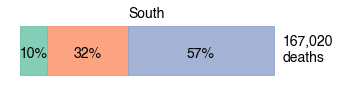

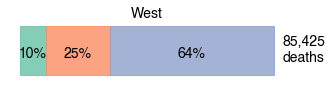

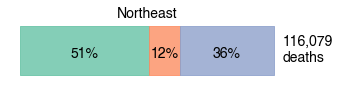

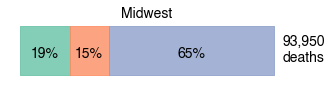

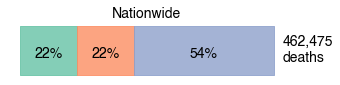

In [21]:
## Plot of deaths by region and time period (Figure 3.1)

def gen_period_plot(p1, p2, p3, ax):
    '''
    Function to plot the percentage of deaths that occurred in each time period
    p1, p2, p3: the cumulative deaths by the end of periods 1, 2, and 3, respectively
    ax: the axis to plot on
    '''
    # Plot bars
    ax.broken_barh([(0, p1), (p1, p2-p1), (p2, p3-p2)], (2,1), color=['#66c2a5','#fc8d62','#8da0cb'], alpha=0.8)
    # Add text within bars
    ax.text(x=p1/2, y=2.45, s=str(int((p1/p3)*100))+'%', fontproperties=prop ,ha='center', va='center', fontsize=14)
    ax.text(x=(p2-p1)/2+p1, y=2.45, s=str(int((p2 - p1)/p3*100))+'%', ha='center', va='center', fontproperties=prop, fontsize=14)
    ax.text(x=(p3-p2)/2+p2, y=2.45, s=str(int((p3 - p2)/p3*100))+'%', ha='center', va='center',fontproperties=prop, fontsize=14)  
    # Add text at end of bar
    plt.text(0.89, 0.35, s='{:,}'.format(int(p3))+'\ndeaths', fontproperties=prop, fontsize=14, transform=plt.gcf().transFigure)
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(top=True,bottom=True,left=True,right=True)
    
# Get regions and plot per region
regions = list(df.Region.unique()) + ['Nationwide']
for r in regions:
    if r == 'Nationwide':
        region_df = df.copy()
    else:
        region_df = df[df.Region == r]
    
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,1))
    ax.set_title("%s"%(r), fontproperties=prop, fontsize=14)
    # Get the total number of deaths per time period
    deaths_p1 = np.sum(region_df[all_dates[:split_1]].values[:,-1])
    deaths_p2 = np.sum(region_df[all_dates[split_1:split_2]].values[:,-1])
    deaths_p3 = np.sum(region_df[all_dates[split_2:]].values[:,-1])
    # plot
    gen_period_plot(deaths_p1, deaths_p2, deaths_p3, ax)

    plt.savefig('../figures/chapter_3/figure_3_1/%s.svg'%(r), bbox_inches='tight')
    plt.show()

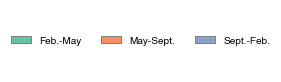

In [22]:
# Separate legend for the above plot
fig = plt.figure(figsize=(2, 1.25))
labels = ['Feb.-May', 'May-Sept.', 'Sept.-Feb.']
cs = ['#66c2a5','#fc8d62','#8da0cb']
patches = [
    mpl.patches.Patch(facecolor=c, label=l, edgecolor='gray')
    for l, c in zip(labels, cs)]
plt.plot() # Empty plot
plt.xticks([])
plt.yticks([])
prop.set_size(10)
fig.legend(patches, labels, loc='center', frameon=False, prop=prop, ncol=3)
sns.despine(top=True, bottom=True, left=True, right=True)
plt.savefig('../figures/chapter_3/figure_3_1/legend.svg', bbox_inches='tight')
plt.show()

#### Census Bureau: land data for population density calculation

In [24]:
landarea = pd.read_csv("../data/LND01.csv")
landarea.head()
df = df.merge(landarea[['STCOU', 'LND110210D']], left_on='FIPS', right_on='STCOU', how='inner')
df = df.rename(columns={'LND110210D':'land_area'})
df['pop_density'] = df.Population / df.land_area
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,2/9/21,2/10/21,2/11/21,2/12/21,cluster,Region,start_day,STCOU,land_area,pop_density
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,75.571429,76.714286,77.714286,78.857143,1,South,131,1001,594.44,93.985936
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,229.142857,230.714286,231.714286,234.142857,1,South,104,1003,1589.78,140.418171
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,44.142857,44.714286,45.142857,45.714286,2,South,190,1005,884.88,27.897568
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,52.571429,52.857143,53.142857,53.857143,2,South,199,1007,622.58,35.969675
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,110.571429,112.142857,113.142857,114.571429,1,South,202,1009,644.78,89.683303


#### ACS: Demographics data

In [25]:
# Columns to pull from ACS
cols = {'B19013_001E':'median_household_income',
        'B01001B_001E':'black',
        'B01001C_001E':'american_indian',
        'B01001D_001E':'asian',
        'B01001E_001E':'pacific_island',
        'B01001F_001E':'other',
        'B01001G_001E':'two_more',
        'B01001I_001E':'hispanic',
        'B01001H_001E':'white_nonhispanic',
        'B01001_001E':'total_population',
        'B06009_001E':'education_total',
        'B06009_002E':'less_than_highschool',
        'B06009_003E':'high_school',
        'B06009_004E':'some_college',
        'B06009_005E':'bachelor',
        'B06009_006E':'graduate_deg'}

# Pull data
census = censusdata.download('acs5', 2018,
                             censusdata.censusgeo([('county', '*')]),
                             list(cols.keys()))
census.rename(columns=cols, inplace=True)

# Race variables
census['per_wnh'] = census.white_nonhispanic / census.total_population
census['per_poc'] = 1 - census.per_wnh
census['per_black'] = census.black / census.total_population
census['per_asian'] = census.asian / census.total_population
census['per_hispanic'] = census.hispanic / census.total_population
census['per_other'] = (census.american_indian + census.pacific_island + census.other + census.two_more) / census.total_population

# Education variables
census['per_atleast_hs'] = 1 - (census.less_than_highschool / census.education_total)
census['per_highschool'] = census.high_school / census.education_total
census['per_college'] = (census.some_college + census.bachelor) / census.education_total
census['per_graddeg'] = census.graduate_deg / census.education_total

# Generate fips
fips = []
for key in census.index:
    ((s1, s), (c1, c)) = key.geo
    fips.append(int(s+c))

census['fips'] = fips
census.reset_index(drop=True, inplace=True)
census.head()

,median_household_income,black,american_indian,asian,pacific_island,other,two_more,hispanic,white_nonhispanic,total_population,...,per_poc,per_black,per_asian,per_hispanic,per_other,per_atleast_hs,per_highschool,per_college,per_graddeg,fips
0,66907.0,23,237,302,17,6,324,337,2050,3255,...,0.370200,0.007066,0.092780,0.103533,0.179416,0.897424,0.318501,0.522717,0.056206,2195
1,35539.0,60,7480,32,2,3,302,81,298,8198,...,0.963650,0.007319,0.003903,0.009880,0.949866,0.777046,0.536357,0.225994,0.014695,2158
2,61606.0,232690,82699,176740,9405,296569,153996,1311091,2368876,4253913,...,0.443130,0.054700,0.041548,0.308208,0.127569,0.873906,0.225791,0.531571,0.116544,4013
3,51352.0,752,4808,246,51,996,1109,12453,19286,37879,...,0.490852,0.019853,0.006494,0.328757,0.183849,0.856402,0.298670,0.501381,0.056351,4009
4,40467.0,248,362,430,0,5376,512,38899,6928,46584,...,0.851279,0.005324,0.009231,0.835029,0.134166,0.756158,0.272239,0.410531,0.073389,4023


In [26]:
# Pull ages. This is easier to do using table profiles
cols_2 = {
     'DP05_0001E':'total_pop',
     'DP05_0004E':'under5',
     'DP05_0005E':'5to9',
     'DP05_0006E':'10to14',
     'DP05_0007E':'15to19',
     'DP05_0008E':'20to24',
     'DP05_0009E':'25to34',
     'DP05_0010E':'35to44',
     'DP05_0011E':'45to54',
     'DP05_0012E':'55to59',
     'DP05_0013E':'60to64',
     'DP05_0014E':'65to74',
     'DP05_0015E':'75to84',
     'DP05_0016E':'85plus'
}
age = censusdata.download('acs5', 2018,
                             censusdata.censusgeo([('county', '*')]),
                             list(cols_2.keys()),
                            tabletype='profile')
age.rename(columns=cols_2, inplace=True)
age['65plus'] = (age['65to74'] +age['75to84'] + age['85plus']) / age.total_pop
age['19under'] = (age['under5'] + age['5to9'] + age['10to14'] + age['15to19']) / age.total_pop
age['20to65'] = 1 - (age['65plus'] + age['19under'])

# Generate fips
fips = []
for key in age.index:
    ((s1, s), (c1, c)) = key.geo
    fips.append(int(s+c))

age['fips'] = fips
age.reset_index(drop=True, inplace=True)
age.head()

,total_pop,under5,5to9,10to14,15to19,20to24,25to34,35to44,45to54,55to59,60to64,65to74,75to84,85plus,65plus,19under,20to65,fips
0,3255,102.7,206,217,197,198,302,320,334,334,259,187,462,188,0.257143,0.222028,0.520829,2195
1,8198,115.2,1086,867,894,750,654,1262,724,788,448,269,299,138,0.086119,0.361332,0.552549,2158
2,4253913,97.9,279161,288352,298170,288250,288489,616000,557229,541839,251853,229293,358732,183578,0.181387,0.203526,0.615088,4013
3,37879,115.8,2819,2781,2965,2957,2826,5722,4751,4161,1814,2071,2882,1562,0.171995,0.229172,0.598833,4009
4,46584,91.7,3342,3836,3350,3793,3035,4924,5204,5500,2784,2925,4644,2396,0.213915,0.227969,0.558117,4023


In [27]:
# Merge census and age data
census = census.merge(age, on='fips', how='inner')
# Merge onto county data
df = df.merge(census, left_on='FIPS', right_on='fips', how='inner').drop('fips', axis=1)
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,35to44,45to54,55to59,60to64,65to74,75to84,85plus,65plus,19under,20to65
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,7064,7374,7853,4131,2694,4711,2524,0.179873,0.198132,0.621995
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,23326,25377,28330,14440,14851,24551,12165,0.247791,0.181232,0.570977
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,3675,3104,3452,1657,1651,2820,1392,0.227407,0.179594,0.592999
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,3075,2895,3439,1494,1216,2122,1112,0.197541,0.171310,0.631149
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,6786,7153,7947,3895,3613,6132,3235,0.225171,0.194454,0.580375


#### PLACES: Obesity data

In [28]:
# Read in dataset
obe = pd.read_csv("../data/PLACES__Local_Data_for_Better_Health__County_Data_2020_release.csv")
# Filter to measure of interest
obe = obe[obe.Measure == 'Obesity among adults aged >=18 years']
obe = obe[obe.Data_Value_Type == 'Age-adjusted prevalence']
obe = obe.rename(columns={'Data_Value':'obesity'})
# Merge
df = df.merge(obe[['LocationID', 'obesity']], left_on="FIPS", right_on='LocationID', how='left').drop('LocationID', axis=1)
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,45to54,55to59,60to64,65to74,75to84,85plus,65plus,19under,20to65,obesity
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,7374,7853,4131,2694,4711,2524,0.179873,0.198132,0.621995,35.5
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,25377,28330,14440,14851,24551,12165,0.247791,0.181232,0.570977,29.4
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,3104,3452,1657,1651,2820,1392,0.227407,0.179594,0.592999,40.8
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,2895,3439,1494,1216,2122,1112,0.197541,0.171310,0.631149,38.4
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,7153,7947,3895,3613,6132,3235,0.225171,0.194454,0.580375,33.7


#### VERA Institute: Incarceration data

In [29]:
# Read in dataset
jails = pd.read_csv('../data/incarceration_trends.csv')
# Filter to 2018, the most recent year with data for all states
jails = jails[jails.year == 2018]
jails.head()

,yfips,year,fips,state,county_name,total_pop,total_pop_15to64,female_pop_15to64,male_pop_15to64,aapi_pop_15to64,...,native_prison_pop_rate,white_prison_pop_rate,total_prison_adm_rate,female_prison_adm_rate,male_prison_adm_rate,aapi_prison_adm_rate,black_prison_adm_rate,latinx_prison_adm_rate,native_prison_adm_rate,white_prison_adm_rate
48,201801001,2018,1001,AL,Autauga County,55601,36279,18555,17724,571.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,201801003,2018,1003,AL,Baldwin County,218022,134713,69440,65273,2041.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,201801005,2018,1005,AL,Barbour County,24881,15808,6912,8896,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195,201801007,2018,1007,AL,Bibb County,22400,14928,6611,8317,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,201801009,2018,1009,AL,Blount County,57840,36295,18030,18265,144.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Calculate the incarceratin percentage
jails['per_incar'] = (jails.total_jail_pop) / jails.total_pop
# No local jails in Delaware, Rhode Island, Vermont, and Connecticut
jails.loc[jails.state.isin(['DE', 'RI', 'VT', 'CT']), 'per_incar'] = 0
# Merge 
df = df.merge(jails[['fips', 'per_incar']], left_on='FIPS', right_on='fips', how='left').drop('fips', axis=1)
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,55to59,60to64,65to74,75to84,85plus,65plus,19under,20to65,obesity,per_incar
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,7853,4131,2694,4711,2524,0.179873,0.198132,0.621995,35.5,0.002968
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,28330,14440,14851,24551,12165,0.247791,0.181232,0.570977,29.4,0.002949
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,3452,1657,1651,2820,1392,0.227407,0.179594,0.592999,40.8,0.004461
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,3439,1494,1216,2122,1112,0.197541,0.171310,0.631149,38.4,0.003705
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,7947,3895,3613,6132,3235,0.225171,0.194454,0.580375,33.7,0.002317


#### CMS: Nursing home data

In [31]:
# Read in data
nursing = pd.read_csv("../data/nursing.csv", sep=',')
nursing = nursing.rename(columns={'Provider State':'state', 'Provider County Name':'county',
                                  'Average Number of Residents per Day':'nursing_pop'})
# Group to get average residents/day at the county-level
nursing = nursing.groupby(['state', 'county'], as_index=False).sum()
# Convert state abbreviations to full names
nursing['state'] = [abbrev_us_state[q] for q in nursing['state'].values]
nursing.head()

,state,county,nursing_pop
0,Alaska,Anchorage,208.3
1,Alaska,Bethel,15.3
2,Alaska,Fairbanks North Star,71.6
3,Alaska,Juneau,55.6
4,Alaska,Kenai Peninsula,97.9


In [32]:
# Merge
df = df.merge(nursing, left_on=['Province_State', 'Admin2'],
                      right_on=['state', 'county'],
                      how='left').drop(['state', 'county'], axis=1)
# We'll say that any counties without CMS providers don't have nursing homes - limited by the data we have
df['nursing_pop'] = df.nursing_pop.fillna(0)
df['per_nursing'] = df.nursing_pop / df.Population
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,65to74,75to84,85plus,65plus,19under,20to65,obesity,per_incar,nursing_pop,per_nursing
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,2694,4711,2524,0.179873,0.198132,0.621995,35.5,0.002968,118.4,0.002119
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,14851,24551,12165,0.247791,0.181232,0.570977,29.4,0.002949,496.3,0.002223
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,1651,2820,1392,0.227407,0.179594,0.592999,40.8,0.004461,135.2,0.005477
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,1216,2122,1112,0.197541,0.171310,0.631149,38.4,0.003705,103.8,0.004635
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,3613,6132,3235,0.225171,0.194454,0.580375,33.7,0.002317,179.1,0.003097


#### CDC: Social vulnerability index data to get household crowding

In [33]:
## This dataset contains all the information used within in the SVI. This is from 2018.

svi = pd.read_csv("../data/SVI2018_US_COUNTY.csv")
column_mapping = {"E_CROWD":"crowding"}
svi.rename(columns=column_mapping, inplace=True)

# Uncomment this to only keep the named columns from above (commented to be able to pick apart CDC SVI more)
keep_cols = ["FIPS"] + list(column_mapping.values())
svi = svi[keep_cols]

svi.head()

,FIPS,crowding
0,35039,264
1,1001,299
2,1009,339
3,1013,119
4,1015,772


In [34]:
# Merge
df = df.merge(svi, on="FIPS", how="left")
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,75to84,85plus,65plus,19under,20to65,obesity,per_incar,nursing_pop,per_nursing,crowding
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,4711,2524,0.179873,0.198132,0.621995,35.5,0.002968,118.4,0.002119,299
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,24551,12165,0.247791,0.181232,0.570977,29.4,0.002949,496.3,0.002223,991
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,2820,1392,0.227407,0.179594,0.592999,40.8,0.004461,135.2,0.005477,313
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,2122,1112,0.197541,0.171310,0.631149,38.4,0.003705,103.8,0.004635,52
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,6132,3235,0.225171,0.194454,0.580375,33.7,0.002317,179.1,0.003097,339


#### New York Times: Election data 

In [35]:
## Code for this section was found at https://github.com/tonmcg/US_County_Level_Election_Results_08-20/blob/master/2020_US_County_Level_Presidential_Results.ipynb

election_url = "https://static01.nyt.com/elections-assets/2020/data/api/2020-11-03/national-map-page/national/president.json"

# make an http request for the page
election_request = requests.request(
    method='GET', 
    url=election_url,
    headers={ "Accept": "application/json" }
)

election_response = election_request.json()

election_data = election_response['data']['races']

In [36]:
## parse response into dataframe, and select and rename final columns
election_data_df = pd.DataFrame(election_data)[['state_name', 'counties']].rename(columns={"state_name": "t_state_name"})

# after https://stackoverflow.com/a/49962887
# unnest 'counties' column, turning object keys in dataframe columns and object values into rows, select certain keys from each array, and rename those keys (columns)
election_data_df = pd.DataFrame(
    [
        dict(y, t_state_name=i) for i, x in zip(
            election_data_df['t_state_name'],
            election_data_df['counties']
        ) for y in x
    ]
)[['fips', 'votes', 'results']].rename(columns={"fips": "geoid", "votes": "total_votes"})

# after https://stackoverflow.com/a/38231651
## unravel dictionary (JSON object) into other columns, choose final columns, rename them, and cast their data types
election_data_df = pd.concat(
    [
        election_data_df.drop(['results'], axis=1), 
        election_data_df['results'].apply(pd.Series)
    ], 
    axis=1
)[['geoid', 'total_votes', 'trumpd', 'bidenj']].rename(columns={"trumpd": "votes_gop", "bidenj": "votes_dem"})\
    .astype({'votes_gop': 'int64', 'votes_dem': 'int64', 'geoid':'float64'})

election_data_df.head(10)

In [37]:
# Merge
df = df.merge(election_data_df, left_on="FIPS", right_on="geoid", how="left").drop("geoid", axis=1)
df['political_leaning'] = (df.votes_gop - df.votes_dem) / (df.total_votes)
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,20to65,obesity,per_incar,nursing_pop,per_nursing,crowding,total_votes,votes_gop,votes_dem,political_leaning
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,0.621995,35.5,0.002968,118.4,0.002119,299,27770.0,19838.0,7503.0,0.444184
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,0.570977,29.4,0.002949,496.3,0.002223,991,109679.0,83544.0,24578.0,0.537623
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,0.592999,40.8,0.004461,135.2,0.005477,313,10518.0,5622.0,4816.0,0.076631
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,0.631149,38.4,0.003705,103.8,0.004635,52,9595.0,7525.0,1986.0,0.577280
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,0.580375,33.7,0.002317,179.1,0.003097,339,27588.0,24711.0,2640.0,0.800022


#### State governor political affiliation

This isn't really used anymore, but we keep it in case we want to run checks on which governors were more or less strict

In [38]:
# Read in dataset
govs = pd.read_csv("../data/governor_affiliation.csv")
# Filter to just state
start_idx = len('Governor of ')
govs['gov_state'] = [x[start_idx:] for x in govs.state.values]
govs.head()

,state,governor,party,date_sworn_in,gov_state
0,Governor of Alabama,Kay Ivey,Republican,10-Apr-17,Alabama
1,Governor of Alaska,Mike Dunleavy,Republican,3-Dec-18,Alaska
2,Governor of American Samoa,Lemanu Palepoi Mauga,Nonpartisan,3-Jan-21,American Samoa
3,Governor of Arizona,Doug Ducey,Republican,5-Jan-15,Arizona
4,Governor of Arkansas,Asa Hutchinson,Republican,13-Jan-15,Arkansas


In [39]:
# merge
df = df.merge(govs[['gov_state', 'party', 'date_sworn_in']], left_on='Province_State', right_on='gov_state',how='left') \
        .drop('gov_state', axis=1).rename(columns={'party':'governor_party'})
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,per_incar,nursing_pop,per_nursing,crowding,total_votes,votes_gop,votes_dem,political_leaning,governor_party,date_sworn_in
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,0.002968,118.4,0.002119,299,27770.0,19838.0,7503.0,0.444184,Republican,10-Apr-17
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,0.002949,496.3,0.002223,991,109679.0,83544.0,24578.0,0.537623,Republican,10-Apr-17
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,0.004461,135.2,0.005477,313,10518.0,5622.0,4816.0,0.076631,Republican,10-Apr-17
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,0.003705,103.8,0.004635,52,9595.0,7525.0,1986.0,0.577280,Republican,10-Apr-17
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,0.002317,179.1,0.003097,339,27588.0,24711.0,2640.0,0.800022,Republican,10-Apr-17


#### OxCGRT: Governor policy strigency data

In [40]:
# Read in dataset
resps = pd.read_csv("../data/OxCGRT_US_latest.csv")
# Filter to just state-wide responses
resps = resps[['RegionName', 'Jurisdiction', 'Date', 'StringencyIndex']]
state_resps = resps[resps.Jurisdiction == 'STATE_WIDE']
# We'll only look at responses that have a stringency greater than 0
state_resps['num_responses'] = list((state_resps.StringencyIndex.values > 0).astype(int))
state_resps.head()

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,RegionName,Jurisdiction,Date,StringencyIndex,num_responses
408,Alaska,STATE_WIDE,20200101,0.0,0
409,Alaska,STATE_WIDE,20200102,0.0,0
410,Alaska,STATE_WIDE,20200103,0.0,0
411,Alaska,STATE_WIDE,20200104,0.0,0
412,Alaska,STATE_WIDE,20200105,0.0,0


In [41]:
# Group by to ge average stringency across the entire pandemic
state_agg = state_resps[['RegionName', 'StringencyIndex', 'num_responses']].groupby(['RegionName'], as_index=False).sum()
state_agg['average_strict'] = state_agg.StringencyIndex / state_agg.num_responses
state_agg.head()

,RegionName,StringencyIndex,num_responses,average_strict
0,Alabama,12145.58,333,36.473213
1,Alaska,18183.44,391,46.504962
2,Arizona,14665.32,381,38.491654
3,Arkansas,14974.88,335,44.701134
4,California,21185.31,389,54.460951


In [42]:
# See what dates are 4 weeks from our splits
print(all_dates[split_1-28], all_dates[split_2-28], all_dates[-1-28])

5/6/20 9/10/20 1/15/21


In [43]:
## Get average stingency in each period
resp_dates = list(state_resps.Date.unique())
# Get splits to account for a possible 4-week lag between an intervention and deaths
s1, s2, s3 = resp_dates.index(20200506), resp_dates.index(20200910),  resp_dates.index(20210115)
# Filter for each period and calculate stringency
state_resps_p1 = state_resps[state_resps.Date.isin(resp_dates[:s1])].groupby(['RegionName'], as_index=False).sum()
state_resps_p2 = state_resps[state_resps.Date.isin(resp_dates[s1:s2])].groupby(['RegionName'], as_index=False).sum()
state_resps_p3 = state_resps[state_resps.Date.isin(resp_dates[s2:s3])].groupby(['RegionName'], as_index=False).sum()
state_resps_p1['strict_p1'] = state_resps_p1.StringencyIndex / state_resps_p1.num_responses
state_resps_p2['strict_p2'] = state_resps_p2.StringencyIndex / state_resps_p2.num_responses
state_resps_p3['strict_p3'] = state_resps_p3.StringencyIndex / state_resps_p3.num_responses
state_agg = state_agg.merge(state_resps_p1[['RegionName', 'strict_p1']], on='RegionName')\
            .merge(state_resps_p2[['RegionName', 'strict_p2']], on='RegionName')\
            .merge(state_resps_p3[['RegionName', 'strict_p3']], on='RegionName')
state_agg.head()

,RegionName,StringencyIndex,num_responses,average_strict,strict_p1,strict_p2,strict_p3
0,Alabama,12145.58,333,36.473213,52.743684,38.140236,29.454882
1,Alaska,18183.44,391,46.504962,37.628824,47.485433,52.529764
2,Arizona,14665.32,381,38.491654,30.033168,45.316850,37.363858
3,Arkansas,14974.88,335,44.701134,42.552321,50.082126,40.135984
4,California,21185.31,389,54.460951,40.116273,61.635669,58.462913


In [44]:
# Get governor parties if we want to do analysis on that
state_agg = state_agg.merge(govs, left_on='RegionName', right_on='gov_state', how='left')
state_agg.head()

,RegionName,StringencyIndex,num_responses,average_strict,strict_p1,strict_p2,strict_p3,state,governor,party,date_sworn_in,gov_state
0,Alabama,12145.58,333,36.473213,52.743684,38.140236,29.454882,Governor of Alabama,Kay Ivey,Republican,10-Apr-17,Alabama
1,Alaska,18183.44,391,46.504962,37.628824,47.485433,52.529764,Governor of Alaska,Mike Dunleavy,Republican,3-Dec-18,Alaska
2,Arizona,14665.32,381,38.491654,30.033168,45.316850,37.363858,Governor of Arizona,Doug Ducey,Republican,5-Jan-15,Arizona
3,Arkansas,14974.88,335,44.701134,42.552321,50.082126,40.135984,Governor of Arkansas,Asa Hutchinson,Republican,13-Jan-15,Arkansas
4,California,21185.31,389,54.460951,40.116273,61.635669,58.462913,Governor of California,Gavin Newsom,Democratic,2019,California


In [45]:
# Bucket based on governor stringency in each period, for plotting in our descriptive analysis (Figure 3.5)
for p in range(1,4):
    # Split based on quantiles
    buckets = pd.qcut(state_agg['strict_p%i'%(p)].values, q=3).astype(str)
    # Get buckets
    b_name = 'strict_p%i_bucket'%(p) 
    unique_bins = np.unique(buckets)
    # Find the start threshold of each bucket for sorting purposes
    sort_idxs = np.argsort([float(q[1:q.find(',')]) for q in unique_bins])
    sorted_bins = unique_bins[sort_idxs]
    # Names of buckets
    bucket_mapping = {sorted_bins[0]:'loose', sorted_bins[1]:'middle', sorted_bins[2]:'strict'}
    state_agg[b_name] = [bucket_mapping[q] for q in buckets]
state_agg.head()

,RegionName,StringencyIndex,num_responses,average_strict,strict_p1,strict_p2,strict_p3,state,governor,party,date_sworn_in,gov_state,strict_p1_bucket,strict_p2_bucket,strict_p3_bucket
0,Alabama,12145.58,333,36.473213,52.743684,38.140236,29.454882,Governor of Alabama,Kay Ivey,Republican,10-Apr-17,Alabama,strict,loose,loose
1,Alaska,18183.44,391,46.504962,37.628824,47.485433,52.529764,Governor of Alaska,Mike Dunleavy,Republican,3-Dec-18,Alaska,loose,loose,strict
2,Arizona,14665.32,381,38.491654,30.033168,45.316850,37.363858,Governor of Arizona,Doug Ducey,Republican,5-Jan-15,Arizona,loose,loose,loose
3,Arkansas,14974.88,335,44.701134,42.552321,50.082126,40.135984,Governor of Arkansas,Asa Hutchinson,Republican,13-Jan-15,Arkansas,middle,middle,loose
4,California,21185.31,389,54.460951,40.116273,61.635669,58.462913,Governor of California,Gavin Newsom,Democratic,2019,California,middle,strict,strict


In [46]:
# Merge
df = df.merge(state_agg[['RegionName', 'average_strict', 'strict_p1', 'strict_p2', 'strict_p3',
                         'strict_p1_bucket', 'strict_p2_bucket', 'strict_p3_bucket']], 
              left_on='Province_State', right_on='RegionName',how='left') \
        .drop('RegionName', axis=1)
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,political_leaning,governor_party,date_sworn_in,average_strict,strict_p1,strict_p2,strict_p3,strict_p1_bucket,strict_p2_bucket,strict_p3_bucket
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,0.444184,Republican,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,0.537623,Republican,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,0.076631,Republican,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,0.577280,Republican,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,0.800022,Republican,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose


#### Transportation department: aviation data

In [47]:
# Read and filter to 2019
airports = pd.read_csv('../data/International_Report_Passengers.csv')
airports = airports[(airports.Year == 2019) & (airports.type == "Passengers")]
airports.head()

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
3995,12/01/2019,2019,12,99999,ZZZ,1,16263,YYJ,906,20272,KAH,1,Passengers,0,4,4
3996,12/01/2019,2019,12,99999,ZZZ,1,14682,SAQ,204,21743,2LQ,1,Passengers,0,10,10
3997,12/01/2019,2019,12,99999,ZZZ,1,13605,NAS,204,21743,2LQ,1,Passengers,0,19,19
3999,12/01/2019,2019,12,99999,ZZZ,1,11519,EIS,282,21743,2LQ,1,Passengers,0,10,10
4000,12/01/2019,2019,12,99999,ZZZ,1,10916,CCZ,204,21743,2LQ,1,Passengers,0,1,1


In [48]:
# We only care about the airport code and total scheduled passenger traffic
keep_cols = ['usg_apt', 'Total']
# Get average across the year
airports = airports[keep_cols].groupby('usg_apt', as_index=False).mean()
airports.head()

,usg_apt,Total
0,ABE,87.000000
1,ABI,51.250000
2,ABQ,245.727273
3,ACK,5.428571
4,ACT,29.000000


In [49]:
# Our airport --> county mapping dataset uses FAA codes, whereas the transportation data uses IATA codes
# These codes are almost always the same, but some codes are different. This code maps IATA codes --> FAA codes for 
# airports where those codes are different
iata_to_faa = {'KLW':'AKW', 'AZA':'IWA', 'YUM':'NYL', 'FCA':'GPI', 'BLD':'BVU', 'USA':'JQF', 'SCE':'UNV','HHH':'HXD',
              'ESD':'ORS','FRD':'FHR'}
airports['faa'] = [iata_to_faa[q] if q in iata_to_faa.keys() else q for q in airports.usg_apt.values]
airports.head()

,usg_apt,Total,faa
0,ABE,87.000000,ABE
1,ABI,51.250000,ABI
2,ABQ,245.727273,ABQ
3,ACK,5.428571,ACK
4,ACT,29.000000,ACT


In [50]:
# Now get county names and merge on
airport_counties = pd.read_csv("../data/vale_eligible_airports.csv")
airport_counties = airport_counties[['State', 'Loc ID', 'County', 'Enplanements', 'Airport Name']]
airports = airports.merge(airport_counties, left_on='faa', right_on='Loc ID', how='inner')
# Convert to full state names
airports['state_name'] = [abbrev_us_state[q] for q in airports.State.values]
# Certain counties have additions to their names, so we clean those 
county_names = []
for c in airports.County.values:
    idx = c.find('(CA)')
    if idx >= 0:
        county_names.append(c[:idx-1])
    else:
        county_names.append(c)
airports['county_name'] = county_names
airports.head()

,usg_apt,Total,faa,State,Loc ID,County,Enplanements,Airport Name,state_name,county_name
0,ABE,87.000000,ABE,PA,ABE,Lehigh,"320,544",Lehigh Valley International,Pennsylvania,Lehigh
1,ABI,51.250000,ABI,TX,ABI,Taylor,"86,000",Abilene Regional,Texas,Taylor
2,ABQ,245.727273,ABQ,NM,ABQ,Bernalillo,"2,323,883",Albuquerque International Sunport,New Mexico,Bernalillo
3,ACK,5.428571,ACK,MA,ACK,Nantucket,"155,952",Nantucket Memorial,Massachusetts,Nantucket
4,ACT,29.000000,ACT,TX,ACT,McLennan,"62,882",Waco Regional,Texas,McLennan


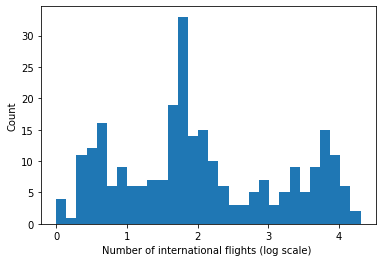

,usg_apt,Total,faa,State,Loc ID,County,Enplanements,Airport Name,state_name,county_name
0,ABE,87.000000,ABE,PA,ABE,Lehigh,med_airport,Lehigh Valley International,Pennsylvania,Lehigh
1,ABI,51.250000,ABI,TX,ABI,Taylor,med_airport,Abilene Regional,Texas,Taylor
2,ABQ,245.727273,ABQ,NM,ABQ,Bernalillo,large_airport,Albuquerque International Sunport,New Mexico,Bernalillo
3,ACK,5.428571,ACK,MA,ACK,Nantucket,small_airport,Nantucket Memorial,Massachusetts,Nantucket
4,ACT,29.000000,ACT,TX,ACT,McLennan,small_airport,Waco Regional,Texas,McLennan


In [51]:
## Look into the size of airports 

# Check size of airports
plt.figure()
plt.hist(np.log10(airports.Total.values), bins=30)
plt.xlabel("Number of international flights (log scale) ")
plt.ylabel("Count")
plt.show()

# Based on this, we'll split airports into thirds
buckets = pd.qcut(np.log10(airports.Total.values), q=3, 
                  labels=['small_airport', 'med_airport', 'large_airport'], retbins=False).astype(str)
airports['Enplanements'] = buckets
airports.head()

In [52]:
# We only care if a county has large airport or not. Some counties have multiple airports
order = ['no airport',  'small_airport', 'med_airport', 'large_airport']
# Sort our dataset by the size of airport in that county
airports["order_code"] = [order.index(q) for q in airports.Enplanements.values]
airports = airports.sort_values(["order_code"], ascending=False)
# Drop duplicates keeps the first of duplicate rows, which because we sorted, will be the the row that says that the county
# has a large airport if that county has a large airport (i.e. we don't want to accidentally drop a row that says a county
# has a large airport)
airports = airports.drop_duplicates(subset=['County', 'state_name'])
airports.head()

,usg_apt,Total,faa,State,Loc ID,County,Enplanements,Airport Name,state_name,county_name,order_code
132,JFK,14892.791218,JFK,NY,JFK,Queens,large_airport,John F Kennedy International,New York,Queens,3
180,OAK,4792.376623,OAK,CA,OAK,Alameda,large_airport,Metropolitan Oakland International,California,Alameda,3
86,FOE,777.000000,FOE,KS,FOE,Shawnee,large_airport,Topeka Regional,Kansas,Shawnee,3
184,OMA,760.833333,OMA,NE,OMA,Douglas,large_airport,Eppley Airfield,Nebraska,Douglas,3
84,FLL,6360.151899,FLL,FL,FLL,Broward,large_airport,Fort Lauderdale/Hollywood International,Florida,Broward,3


In [53]:
# We can now merge with our df
df = df.merge(airports[['state_name', 'county_name', 'Enplanements']], 
                      left_on=['Province_State', 'Admin2'],
                      right_on=['state_name', 'county_name'],
                      how='left'). drop(['state_name', 'county_name'], axis=1)
df['Enplanements'] = df.Enplanements.fillna('no airport')
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,governor_party,date_sworn_in,average_strict,strict_p1,strict_p2,strict_p3,strict_p1_bucket,strict_p2_bucket,strict_p3_bucket,Enplanements
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,Republican,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,Republican,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,Republican,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,Republican,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,Republican,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport


In [54]:
## We'll now calculate the distance from a county to the nearest county with a large airport (0 if a county has one)
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Code: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles. Use 6371 for kilometers
    return c * r

# Counties with large airports
county_with_airport = df[df.Enplanements == "large_airport"][["Lat", "Long_"]].values

# Get minimum distance from county center to the center of a county with a large airport 
min_dists = np.zeros(len(df))
for i in range(len(df)):
    c = df.iloc[[i]]
    lat, lon = c.Lat, c.Long_
    min_dist = np.inf
    for j in county_with_airport:
        d = haversine(lon, lat, j[1], j[0])
        if d < min_dist:
            min_dist = d
    min_dists[i] = min_dist
    
df["dist_to_airport"] = min_dists
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,date_sworn_in,average_strict,strict_p1,strict_p2,strict_p3,strict_p1_bucket,strict_p2_bucket,strict_p3_bucket,Enplanements,dist_to_airport
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport,152.861623
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport,157.966295
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport,143.242244
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport,162.982182
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,10-Apr-17,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport,121.344346


#### Delphi: mask use data

In [55]:
# Fetch data
res = covidcast.signal(data_source='fb-survey', signal='smoothed_wearing_mask')
res.head()

,geo_value,signal,time_value,issue,lag,value,stderr,sample_size,geo_type,data_source
0,01000,smoothed_wearing_mask,2020-09-08,2020-12-09,92,87.874513,1.706219,366.0096,county,fb-survey
1,02000,smoothed_wearing_mask,2020-09-08,2020-12-09,92,78.712871,4.093374,100.0000,county,fb-survey
2,04000,smoothed_wearing_mask,2020-09-08,2020-12-09,92,75.423725,3.754089,131.5270,county,fb-survey
3,04013,smoothed_wearing_mask,2020-09-08,2020-12-09,92,90.151765,1.594534,349.1927,county,fb-survey
4,04019,smoothed_wearing_mask,2020-09-08,2020-12-09,92,88.463022,2.866823,124.1801,county,fb-survey


In [56]:
# Construct empty dataframe to house results
mask_wearing = pd.DataFrame()
# Add unique geo values
mask_wearing['geo_value'] = res.geo_value.unique()
# We don't have enough data for periods 1 and 2 so we'll only use p3. We'll account for a 4 week lag between deaths and 
# mask usage
res_p3 = res[(res.time_value >= '2020-09-10') & (res.time_value <= '2021-01-15')]

averages_p3 = []
for g in mask_wearing.geo_value.values:
    county_p3 = res_p3[res_p3.geo_value == g]
    averages_p3.append(np.nanmean(county_p3.value.values))
    
mask_wearing['public_mask_usage_p3'] = averages_p3
mask_wearing['geo_value'] = mask_wearing.geo_value.astype(int)
mask_wearing.head()

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


,geo_value,public_mask_usage_p3
0,1000,82.712261
1,2000,80.975235
2,4000,83.494976
3,4013,90.549246
4,4019,92.361629


In [57]:
# Final merge!
df = df.merge(mask_wearing, left_on="FIPS", right_on='geo_value', how='left').drop('geo_value', axis=1)
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,average_strict,strict_p1,strict_p2,strict_p3,strict_p1_bucket,strict_p2_bucket,strict_p3_bucket,Enplanements,dist_to_airport,public_mask_usage_p3
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport,152.861623,NaN
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport,157.966295,79.557943
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport,143.242244,NaN
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport,162.982182,NaN
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,36.473213,52.743684,38.140236,29.454882,strict,loose,loose,no airport,121.344346,NaN


## Section 3: Calculating Death Rates

In [58]:
# Filter dataframe if we want a population cutoff
lambda_df = df.copy()
lambda_df = lambda_df[lambda_df.Population >= POPULATION_CUTOFF].reset_index()

# Calcualte the period in which a county is seeded
period_seeded = []
start_days = lambda_df.start_day.values
for i in range(len(lambda_df)):
    s = start_days[i]
    # County never seeded
    if s < 0:
        period_seeded.append(np.nan)
    elif s < split_1:
        period_seeded.append(1)
    elif s < split_2:
        period_seeded.append(2)
    else:
        period_seeded.append(3)

lambda_df['period_seeded'] = period_seeded
lambda_df.head()

,index,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,...,strict_p1,strict_p2,strict_p3,strict_p1_bucket,strict_p2_bucket,strict_p3_bucket,Enplanements,dist_to_airport,public_mask_usage_p3,period_seeded
0,0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,...,52.743684,38.140236,29.454882,strict,loose,loose,no airport,152.861623,NaN,2.0
1,1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,...,52.743684,38.140236,29.454882,strict,loose,loose,no airport,157.966295,79.557943,1.0
2,2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,...,52.743684,38.140236,29.454882,strict,loose,loose,no airport,143.242244,NaN,2.0
3,3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,...,52.743684,38.140236,29.454882,strict,loose,loose,no airport,162.982182,NaN,2.0
4,4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,...,52.743684,38.140236,29.454882,strict,loose,loose,no airport,121.344346,NaN,2.0


In [59]:
def smooth_series_linear(daily):
    '''
    Additional linear smoothing using SMOOTH number of days
    '''
    smoothed = np.zeros(len(daily))
    for i in range(SMOOTH-1, len(daily)):
        subset = daily[i-SMOOTH:i+1]
        if np.sum(subset) == 0:
            continue
        smoothed[i] = np.nanmean(daily[i-SMOOTH:i+1])
    return smoothed

# Array to store results
data_vals = []
# We'll go one county at a time
for i in range(len(lambda_df)):
    # Filter to county
    county = lambda_df.iloc[i]
    cum_cases = county[all_dates]
    seed_p = county.period_seeded
    
    # Get daily deaths (this is what is used for event detection)
    daily = np.insert(np.diff(cum_cases), 0, np.nan)
    daily[daily < 0] = 0
    # Smooth
    smoothed = smooth_series_linear(daily)
    
    # Split series
    series_1 = smoothed[:split_1]
    series_2 = smoothed[split_1:split_2]
    series_3 = smoothed[split_2:]
    
    # Get deaths for seeded counties
    deaths_1, deaths_2, deaths_3 = np.nan, np.nan, np.nan
    if seed_p == 1:
        deaths_1 = np.nansum(daily[:split_1])
    if seed_p <= 2:
        deaths_2 = np.nansum(daily[split_1:split_2])
    if seed_p <= 3:
        deaths_3 = np.nansum(daily[split_2:])
        
    data_vals.append([deaths_1, deaths_2, deaths_3])

# Calculate rates
data_vals = np.array(data_vals)
lambda_df['deaths_1'] = data_vals[:,0]
lambda_df['deaths_2'] = data_vals[:,1]
lambda_df['deaths_3'] = data_vals[:,2]
lambda_df['rate_1'] = (lambda_df.deaths_1 * 10000) / (lambda_df.Population) 
lambda_df['rate_2'] = (lambda_df.deaths_2 * 10000) / (lambda_df.Population) 
lambda_df['rate_3'] = (lambda_df.deaths_3 * 10000) / (lambda_df.Population) 


lambda_df.head()

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


,index,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,...,Enplanements,dist_to_airport,public_mask_usage_p3,period_seeded,deaths_1,deaths_2,deaths_3,rate_1,rate_2,rate_3
0,0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,...,no airport,152.861623,NaN,2.0,NaN,23.285714,52.857143,NaN,4.167913,9.460907
1,1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,...,no airport,157.966295,79.557943,1.0,9.0,44.714286,180.428571,0.403164,2.003023,8.082486
2,2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,...,no airport,143.242244,NaN,2.0,NaN,6.000000,38.714286,NaN,2.430527,15.682689
3,3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,...,no airport,162.982182,NaN,2.0,NaN,9.857143,45.285714,NaN,4.401689,20.222253
4,4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,...,no airport,121.344346,NaN,2.0,NaN,14.142857,99.428571,NaN,2.445761,17.194440


## Section 4: Descriptive Analysis

In [60]:
# Bucket based on variables
n_buckets = 5
indp_vars = ['median_household_income', 'political_leaning', 'pop_density', 'crowding', 'per_poc','public_mask_usage_p3']

all_buckets = []
for v in indp_vars:
    new_name = v+"_bucket"
    # Use pre-determined cutoffs for POC variables
    if v == 'per_poc':
        bins = pd.IntervalIndex.from_tuples([(0, 0.172), (0.172, 0.302), (0.302, 0.443), (0.443, 0.61), (0.61, 1)])
        lambda_df[new_name] = pd.cut(lambda_df[v], bins=bins).astype(str)
    # Otherwise bucket based on quantiles
    else:
        lambda_df[new_name] = pd.qcut(lambda_df[v], q=n_buckets).astype(str)
    if 'mask' not in v:
        all_buckets.append(new_name)
        
all_buckets.append('mask_bucket')
lambda_df.head()

,index,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,...,deaths_3,rate_1,rate_2,rate_3,median_household_income_bucket,political_leaning_bucket,pop_density_bucket,crowding_bucket,per_poc_bucket,public_mask_usage_p3_bucket
0,0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,...,52.857143,NaN,4.167913,9.460907,"(52506.0, 59743.0]","(0.291, 0.455]","(64.907, 167.352]","(149.0, 310.0]","(0.172, 0.302]",nan
1,1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,...,180.428571,0.403164,2.003023,8.082486,"(52506.0, 59743.0]","(0.455, 0.591]","(64.907, 167.352]","(758.0, 378286.0]","(0.0, 0.172]","(70.435, 86.806]"
2,2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,...,38.714286,NaN,2.430527,15.682689,"(20187.999, 40870.4]","(0.0512, 0.291]","(12.959, 33.077]","(310.0, 758.0]","(0.443, 0.61]",nan
3,3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,...,45.285714,NaN,4.401689,20.222253,"(40870.4, 46978.8]","(0.455, 0.591]","(33.077, 64.907]","(-0.001, 61.0]","(0.172, 0.302]",nan
4,4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,...,99.428571,NaN,2.445761,17.194440,"(46978.8, 52506.0]","(0.591, 0.931]","(64.907, 167.352]","(310.0, 758.0]","(0.0, 0.172]",nan


In [61]:
# Plotted names for each bucket
bucket_to_string = {'median_household_income_bucket':'Median Household Income', 
                    'political_leaning_bucket':'Political Leaning', 
                    'pop_density_bucket':'Population Density', 
                    'crowding_bucket':'Household Crowding', 
                    'per_poc_bucket':'Percent POC', 
                    'public_mask_usage_p3_bucket':'Mask Usage'}

In [62]:
# Color palette and specific colors for periods
sns.set_palette("Set2")
colors = ['#66c2a5','#fc8d62','#8da0cb']

# Set some plotting params
# This is largely from https://jwalton.info/Embed-Publication-Matplotlib-Latex/
sns.set(
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "#1D1C1C",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "#1D1C1C",
 "xtick.bottom": False,
 "xtick.color": "#1D1C1C",
 "xtick.top": False,
 "ytick.color": "#1D1C1C"})

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

# font = {'fontname':'Tahoma'}
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [63]:
## Helper functions for plotting
def get_buckets(metric):
    '''
    Get the sorted bucket values for a given metric
    '''
    buckets = lambda_df[metric].unique()
    # There might be a nan value, which we can't sort
    try:
        sort_idxs = np.argsort([float(q[1:q.find(',')]) for q in buckets])
    except ValueError:
        buckets = np.delete(buckets, np.where(buckets == 'nan')[0][0])
        sort_idxs = np.argsort([float(q[1:q.find(',')]) for q in buckets])
    buckets = buckets[sort_idxs]
    return buckets

def get_seeded_stats(data, bucket_df, period):
    '''
    Calculate the median death rate for counties in a bucket
    '''
    
    # Filter based on governor stringency
    data_group_1 = data[(bucket_df['strict_p%i_bucket'%(period)].values == "loose") & (data >= 0)]
    data_group_2 = data[(bucket_df['strict_p%i_bucket'%(period)].values == "middle")  & (data >= 0)]
    data_group_3 = data[(bucket_df['strict_p%i_bucket'%(period)].values == "strict") & (data >= 0)]
    
    # Also return how many counties are seeded in a period
    return [np.nanmedian(data_group_1), 
            np.nanmedian(data_group_2), 
            np.nanmedian(data_group_3),
            round(np.sum(~np.isnan(data_group_1)),0), 
            round(np.sum(~np.isnan(data_group_2)),0), 
            round(np.sum(~np.isnan(data_group_3)),0)]


def get_unseeded_stats(data, bucket_df, period):
    '''
    Calculate the proportion of counties that are seeded in a given bucket and period
    '''
    
    # Filter based on governor stingency
    data_group_1 = data[bucket_df['strict_p%i_bucket'%(period)].values == "loose"]
    data_group_2 = data[bucket_df['strict_p%i_bucket'%(period)].values == "middle"]
    data_group_3 = data[bucket_df['strict_p%i_bucket'%(period)].values == "strict"]
    
    # Also return how many counties are seeded in a period
    return [np.sum(~np.isnan(data_group_1)) / len(data_group_1), 
            np.sum(~np.isnan(data_group_2)) / len(data_group_2),
            np.sum(~np.isnan(data_group_3)) / len(data_group_3),
            round(np.sum(~np.isnan(data_group_1)),0), 
            round(np.sum(~np.isnan(data_group_2)),0), 
            round(np.sum(~np.isnan(data_group_3)),0)]

def get_period_data(period, buckets, metric, seeded=True):
    '''
    Get the summary statistic for a given metric in a given period
    seeded: toggles the summary statistic (death rate for counties that have been seeded, otherwise proportion seeded)
    '''
    severity_medians = []
    for b in buckets:
        bucket_df = lambda_df.loc[lambda_df[metric] == b]
        data_rate = bucket_df['rate_'+str(period)].values
        
        if seeded:
            severity_medians.append(get_seeded_stats(data_rate, bucket_df, period))
        else:
            severity_medians.append(get_unseeded_stats(data_rate, bucket_df, period))
        
    return severity_medians

def get_labels(metric):
    '''
    Get x axis labels based on metric (political leaning has different labels)
    '''
    if metric == "Political Leaning":
        labels = ['Dem.', 'Weak Rep.', 'Rep.']
    else:
        labels = ['Low', 'Middle',  'High']
    return labels
        
def get_line_qualities(period):
    '''
    Set line qualities based on a given period. Returns the marker style, transparency, width, and marker size
    '''
    style='^'
    if period == 1:
        alpha = 0.3
        w = 1
        m_size = 2
    elif period == 2:
        alpha=0.6
        w = 2.5
        style="s"
        m_size = 3
    elif period == 3:
        alpha=0.9
        w = 4
        style="o"
        m_size=4
    kwargs = {'marker':style, 'alpha':alpha, 'markersize':m_size, 'lw':w}
    return kwargs     

def plot_data(ax, data, metric, period):
    '''
    Plot a line for a given metric in a given period. 
    '''
    kwargs = get_line_qualities(period)
    # Plot lines
    x = [q for q in range(len(data))]
    ax.plot(data[:,0], color='#FE2C2C', label='Loose, period %i'%(period), **kwargs)
    ax.plot(data[:,1], color='#852CFE', label='Middle, period %i'%(period), **kwargs)
    ax.plot(data[:,2], color='#2cbdfe', label='Strict, period %i'%(period), **kwargs)
    
    # Ensure ticks are on
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1On  = True
        tic.label1On = True
        
    # Add labels
    labels = get_labels(metric)
    ax.set_xticks([0,2,4])
    ax.set_xticklabels(labels, rotation=0, fontproperties=prop, fontsize=10)
    sns.despine(left=True, bottom=True, top=True, right=True)
    
def add_yaxis(ax, seeded):
    '''
    Add y axis label and ticks
    '''
    # Get tick locations based on plot type
    if seeded:
        ymin, ymax = ax.get_ylim()
        ys = [np.round(q,1) for q in np.arange(0, ymax+2, 2)]
        ax.set_ylabel("Median death rate", fontproperties=prop, fontsize=11)
    else:
        ys = [np.round(q,1) for q in np.arange(0, 1.2, 0.2)]
        ax.set_ylabel("Fraction seeded", fontproperties=prop, fontsize=11)
    
    # Set y ticks
    ax.set_yticks(ys)
    ax.set_yticklabels(ys,fontproperties=prop, fontsize=10)
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On  = True
        tic.label1On = True
        
    return

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater_equal
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: 
The label1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.label

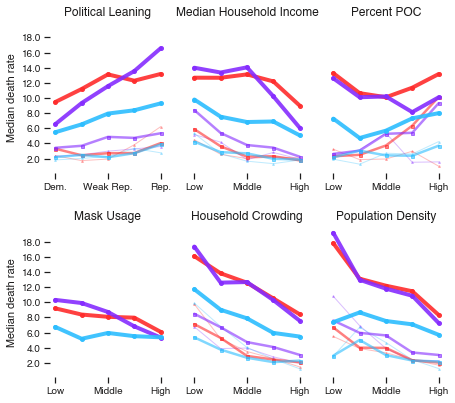

In [65]:
buckets_to_include = ['political_leaning_bucket', 'median_household_income_bucket', 'per_poc_bucket',
                      'public_mask_usage_p3_bucket','crowding_bucket', 'pop_density_bucket']

# Toggle which plot to use
seeded=True

# Prepare for plotting
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols, figsize=set_size(510, subplots=(ncols, nrows)), sharey=True)
plt.subplots_adjust(hspace=0.35)
j,k = 0,0

# List to store number of countis seeded in each bucket
all_counts=[]
for i, metric in enumerate(buckets_to_include):
    # Find axis
    ax = axs[j,k]
    ax.set_title("%s"%(bucket_to_string[metric]), fontproperties=prop, fontsize=12)
    
    # Get bucket
    buckets = get_buckets(metric)
    
    # Only plot p3 for mask use
    range_min = 1
    if metric == 'public_mask_usage_p3_bucket':
        range_min=3
    
    # Plot each period
    for period in range(range_min,4):
        severity_medians = get_period_data(period, buckets, metric, seeded)
        # Plot
        plot_data(ax, np.array(severity_medians), bucket_to_string[metric], period)
            
        # Get the counts for each bucket
        loose_counts = [q for q in np.array(severity_medians)[:,3]]
        middle_counts = [q for q in np.array(severity_medians)[:,4]]
        strict_counts = [q for q in np.array(severity_medians)[:,5]]
        cum_counts = [q for q in loose_counts + middle_counts + strict_counts]
        all_counts.append([bucket_to_string[metric], period] + cum_counts) 
    
    # Only plot y axis on first column of figures
    if k == 0:
        add_yaxis(ax, seeded)
    
    # Advance indices
    k += 1
    if k >= ncols:
        j += 1
        k = 0

prop.set_size(8)
legend = axs[nrows-1, int(ncols/2)+1].legend(bbox_to_anchor=(-2.2,-0.6, 3, 2), frameon=False, loc='lower left', 
                                             ncol=3, mode='expand', prop=prop)
axs[nrows-1, int(ncols/2)+1].get_legend().remove()
plt.savefig("../figures/chapter_3/figure_3_5/line_plot_seeded_%s.svg"%(str(seeded)), bbox_inches='tight')
plt.show()

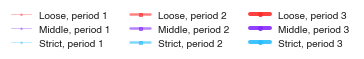

In [66]:
# Add legend as separate figure:
# code location: https://gist.github.com/rldotai/012dbb3294bb2599ff82e61e82356990
# fig.canvas.draw()air
# This gives pixel coordinates for the legend bbox (although perhaps 
# if you are using a different renderer you might get something else).
legend_bbox = legend.get_tightbbox(fig.canvas.get_renderer())
# Convert pixel coordinates to inches
legend_bbox = legend_bbox.transformed(fig.dpi_scale_trans.inverted())

# Create teh separate figure, with appropriate width and height
# Create a separate figure for the legend
legend_fig, legend_ax = plt.subplots(figsize=(legend_bbox.width, legend_bbox.height))

# Recreate the legend on the separate figure/axis
prop.set_size(10)
legend_squared = legend_ax.legend(
    *ax.get_legend_handles_labels(), 
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=legend_fig.transFigure,
    frameon=False,
    fancybox=None,
    shadow=False,
    ncol=3,
    prop=prop
)

# Remove everything else from the legend's figure
legend_ax.axis('off')

plt.savefig("../figures/chapter_3/figure_3_5/legend.svg", bbox_inches='tight')
plt.show()

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater_equal
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: 
The label1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.label

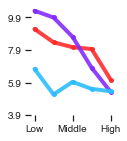

In [67]:
# Plot mask use separtely for inset on Figure 3.5B

seeded=True
metric='public_mask_usage_p3_bucket'
fig, ax = plt.subplots(1, 1, figsize=(1.5, 2))
all_medians = []

for period in range(3,4):
    severity_medians = get_period_data(period, get_buckets(metric), metric, seeded)
    plot_data(ax, np.array(severity_medians), bucket_to_string[metric], period)

ymin, ymax = ax.get_ylim()
ys = [np.round(q,1) for q in np.arange(ymin-1, ymax+1, 2)]
prop.set_size(8)
ax.set_yticks(ys)
ax.set_yticklabels(ys,fontproperties=prop, fontsize=10)
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On  = True
    tic.label1On = True

plt.savefig("../figures/chapter_3/figure_3_5/just_%s.svg"%(metric), bbox_inches='tight', dpi=300)
plt.show()

In [68]:
# We'll also make a dataframe out of the number of seeded counties in each bucket for Table 3.1
count_columns = [q + '_' + str(i+1) for q in ['loose', 'middle', 'strict'] for i in range(5) ]
counts_df = pd.DataFrame(all_counts, columns=['metric', 'period']+count_columns)
# counts_df.to_csv('../data/line_plot_counts.csv', index=False)
counts_df.head()

,metric,period,loose_1,loose_2,loose_3,loose_4,loose_5,middle_1,middle_2,middle_3,middle_4,middle_5,strict_1,strict_2,strict_3,strict_4,strict_5
0,Political Leaning,1,103.0,77.0,45.0,39.0,13.0,129.0,63.0,40.0,8.0,8.0,139.0,101.0,66.0,27.0,9.0
1,Political Leaning,2,91.0,137.0,108.0,126.0,70.0,252.0,176.0,188.0,127.0,124.0,166.0,121.0,73.0,61.0,34.0
2,Political Leaning,3,145.0,172.0,210.0,223.0,187.0,240.0,251.0,259.0,243.0,284.0,203.0,162.0,115.0,101.0,45.0
3,Median Household Income,1,20.0,40.0,50.0,60.0,107.0,26.0,25.0,30.0,55.0,112.0,70.0,54.0,52.0,61.0,105.0
4,Median Household Income,2,103.0,104.0,111.0,120.0,96.0,208.0,161.0,147.0,146.0,205.0,76.0,74.0,84.0,86.0,134.0


## Section 5: Regressions

In [69]:
# Get variables of interest
indp_vars = ['median_household_income', 'political_leaning', 'pop_density', 'crowding',
             'dist_to_airport', 'strict_p1', 'strict_p2', 'strict_p3', 'per_nursing', 'per_incar', 'obesity', 
             'per_wnh', 'per_black', 'per_asian', 'per_other', '19under', '65plus', 'per_atleast_hs', 'per_hispanic', 
             'per_poc', 'public_mask_usage_p3']
dep_vars = ['deaths_1', 'deaths_2', 'deaths_3', 'rate_1', 'rate_2', 'rate_3']
reg_df = lambda_df[['FIPS', 'Population', 'Lat', 'Long_'] + indp_vars + dep_vars + ['period_seeded', 'start_day']].copy()
reg_df = reg_df.rename(columns={'median_household_income':'income', 'Lat':'lat', 'Long_':'lon', 'pop_density':'density'})
reg_df

,FIPS,Population,lat,lon,income,political_leaning,density,crowding,dist_to_airport,strict_p1,...,per_poc,public_mask_usage_p3,deaths_1,deaths_2,deaths_3,rate_1,rate_2,rate_3,period_seeded,start_day
0,1001.0,55869,32.539527,-86.644082,58786.0,0.444184,93.985936,299,152.861623,52.743684,...,0.249783,NaN,NaN,23.285714,52.857143,NaN,4.167913,9.460907,2.0,131
1,1003.0,223234,30.727750,-87.722071,55962.0,0.537623,140.418171,991,157.966295,52.743684,...,0.169812,79.557943,9.0,44.714286,180.428571,0.403164,2.003023,8.082486,1.0,104
2,1005.0,24686,31.868263,-85.387129,34186.0,0.076631,27.897568,313,143.242244,52.743684,...,0.538515,NaN,NaN,6.000000,38.714286,NaN,2.430527,15.682689,2.0,190
3,1007.0,22394,32.996421,-87.125115,45340.0,0.577280,35.969675,52,162.982182,52.743684,...,0.254184,NaN,NaN,9.857143,45.285714,NaN,4.401689,20.222253,2.0,199
4,1009.0,57826,33.982109,-86.567906,48695.0,0.800022,89.683303,339,121.344346,52.743684,...,0.128597,NaN,NaN,14.142857,99.428571,NaN,2.445761,17.194440,2.0,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,56037.0,42343,41.659439,-108.882788,73008.0,0.506294,4.061036,308,172.190214,36.099100,...,0.204230,NaN,NaN,NaN,31.571429,NaN,NaN,7.456115,3.0,299
3059,56039.0,23464,43.935225,-110.589080,83831.0,-0.375213,5.872783,658,235.738100,36.099100,...,0.184136,NaN,NaN,NaN,6.714286,NaN,NaN,2.861526,3.0,363
3060,56041.0,20226,41.287818,-110.547578,58235.0,0.628058,9.718152,219,83.498807,36.099100,...,0.124557,NaN,NaN,NaN,10.000000,NaN,NaN,4.944131,3.0,315
3061,56043.0,7805,43.904516,-107.680187,53426.0,0.646560,3.486632,60,311.252454,36.099100,...,0.179973,NaN,NaN,6.000000,20.000000,NaN,7.687380,25.624600,2.0,223


In [70]:
# Filter so that all counties have all variables available
all_vars = ['income', 'political_leaning', 'density', 'crowding',
             'dist_to_airport', 'strict_p1', 'strict_p2', 'strict_p3',
            'per_nursing', 'per_incar', 'obesity', 'per_wnh', 'per_black', 'per_asian', 'per_other', '19under', '65plus',
            'per_atleast_hs',  'per_hispanic']
for c in all_vars:
    reg_df = reg_df[(reg_df[c].notna()) & (reg_df[c].values != np.inf) & (reg_df[c].values != -1*np.inf)]
reg_df

,FIPS,Population,lat,lon,income,political_leaning,density,crowding,dist_to_airport,strict_p1,...,per_poc,public_mask_usage_p3,deaths_1,deaths_2,deaths_3,rate_1,rate_2,rate_3,period_seeded,start_day
0,1001.0,55869,32.539527,-86.644082,58786.0,0.444184,93.985936,299,152.861623,52.743684,...,0.249783,NaN,NaN,23.285714,52.857143,NaN,4.167913,9.460907,2.0,131
1,1003.0,223234,30.727750,-87.722071,55962.0,0.537623,140.418171,991,157.966295,52.743684,...,0.169812,79.557943,9.0,44.714286,180.428571,0.403164,2.003023,8.082486,1.0,104
2,1005.0,24686,31.868263,-85.387129,34186.0,0.076631,27.897568,313,143.242244,52.743684,...,0.538515,NaN,NaN,6.000000,38.714286,NaN,2.430527,15.682689,2.0,190
3,1007.0,22394,32.996421,-87.125115,45340.0,0.577280,35.969675,52,162.982182,52.743684,...,0.254184,NaN,NaN,9.857143,45.285714,NaN,4.401689,20.222253,2.0,199
4,1009.0,57826,33.982109,-86.567906,48695.0,0.800022,89.683303,339,121.344346,52.743684,...,0.128597,NaN,NaN,14.142857,99.428571,NaN,2.445761,17.194440,2.0,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,56037.0,42343,41.659439,-108.882788,73008.0,0.506294,4.061036,308,172.190214,36.099100,...,0.204230,NaN,NaN,NaN,31.571429,NaN,NaN,7.456115,3.0,299
3059,56039.0,23464,43.935225,-110.589080,83831.0,-0.375213,5.872783,658,235.738100,36.099100,...,0.184136,NaN,NaN,NaN,6.714286,NaN,NaN,2.861526,3.0,363
3060,56041.0,20226,41.287818,-110.547578,58235.0,0.628058,9.718152,219,83.498807,36.099100,...,0.124557,NaN,NaN,NaN,10.000000,NaN,NaN,4.944131,3.0,315
3061,56043.0,7805,43.904516,-107.680187,53426.0,0.646560,3.486632,60,311.252454,36.099100,...,0.179973,NaN,NaN,6.000000,20.000000,NaN,7.687380,25.624600,2.0,223


#### Apply optimal transformations

In [71]:
## Helper function to apply optimal transformations
functions = {'orig':lambda x: x,
            'sqrt':lambda x: np.sqrt(x),
            'sqrd':lambda x: x ** 2,
            'exp':lambda x: np.exp(x),
            'log':lambda x:np.log(x)}
funcs = list(functions.keys())

def get_corrs(x):
    '''
    Get Pearson's correlations between a transformed explanatory variable and death rate or log of death rate
    '''
    orig_corrs, log_corrs = [], []
    for i in range(1,4):
        y = reg_df['rate_%i'%(i)].values
        mask = (y > 0) & (~np.isnan(x))
        orig_corrs.append(np.corrcoef(x[mask], y[mask])[0,1])
        log_corrs.append(np.corrcoef(x[mask], np.log(y[mask]))[0,1])
    return orig_corrs, log_corrs
        

def test_transforms(var_name):
    '''
    Get correlations for each of the possible transformations
    '''
    # Dictionary to store results
    trans_corrs = {}
    # Explanatory variable
    X = reg_df[var_name].values
    # Min-max scaling, adding a small perturbation so that we aren't taking log of 0
    X = (X - np.nanmin(X)) / (np.nanmax(X)- np.nanmin(X)) + 0.000001 
    # Apply each function and find correlations
    for f_name in funcs:
        f = functions[f_name]
        orig_corrs, log_corrs = get_corrs(f(X))
        trans_corrs[f_name+"_orig"] = orig_corrs
        trans_corrs[f_name+"_log"] = log_corrs
    return trans_corrs

def get_optimals(j, names, corrs):
    '''
    Return the optimal correlation in period j
    names: the function names
    corrs: correlations
    '''
    c_orig = np.copy(corrs)
    corrs = np.abs(corrs)[:,j]
    c_orig = c_orig[:,j]
    idx_opt = np.argsort(-1*corrs)[0]
    return names[idx_opt], c_orig[idx_opt]

def apply_optimal(f, v):
    '''
    Apply f to a vector v
    '''
    x = reg_df[v].values
    # Min-max scaling, again adding a small perturbation and then rescaling
    x = (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
    x = f(x+0.000001)
    return (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
        

In [72]:
all_vars = ['income', 'political_leaning', 'density', 'crowding', 'dist_to_airport', 'strict_p1', 'strict_p2', 'strict_p3',
            'per_nursing', 'per_incar', 'obesity', 'per_wnh', 'per_black', 'per_asian', 'per_other', '19under', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon', 'start_day', 'public_mask_usage_p3']

optimal_transforms = {}
for v in all_vars:
    # Get correlations from transformation for the variable
    var_corrs = test_transforms(v)
    # List of transformation
    transforms = np.array(list(var_corrs.keys()))
    # List of correlations
    corrs = np.array([var_corrs[q] for q in transforms])
    print ('--------- %s ---------'%(v))
    for j in range(3):
        # Find the optimal transformation and correlation in period
        t, c = get_optimals(j, transforms, corrs)
        # The first part of t is the transformation applied to x, the second part is the transformation applied to y
        u_idx = t.index("_")
        e_trans, r_trans = t[:u_idx], t[u_idx+1:]
        truth_val = ('strict' in v or 'mask' in v)
        # Mask use and stringency are already period specific and we only look at start day for p1
        if ('strict' not in v and 'mask' not in v and v != 'start_day') or (truth_val and int(v[-1]) == j+1) or (v == 'start_day' and j==0):
            name = 'scaled_'+v
            if not truth_val:
                name += '_p%i'%(j+1)
            optimal_transforms[name] = [e_trans, r_trans]
            reg_df[name] = apply_optimal(functions[e_trans], v)
            print('Period %i optimal: corr %.3f, %s'%(j+1, c, t)) 
    
reg_df.head()

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


--------- income ---------
Period 1 optimal: corr -0.228, log_log
Period 2 optimal: corr -0.469, sqrt_log
Period 3 optimal: corr -0.382, exp_log
--------- political_leaning ---------
Period 1 optimal: corr -0.100, sqrt_orig
Period 2 optimal: corr 0.164, sqrd_log
Period 3 optimal: corr 0.407, exp_log
--------- density ---------
Period 1 optimal: corr -0.240, log_log
Period 2 optimal: corr -0.353, log_orig
Period 3 optimal: corr -0.436, log_orig
--------- crowding ---------
Period 1 optimal: corr -0.354, log_log
Period 2 optimal: corr -0.290, log_orig
Period 3 optimal: corr -0.427, log_orig
--------- dist_to_airport ---------
Period 1 optimal: corr 0.099, log_log
Period 2 optimal: corr 0.148, sqrt_orig
Period 3 optimal: corr 0.277, sqrt_orig
--------- strict_p1 ---------
Period 1 optimal: corr 0.022, log_orig
--------- strict_p2 ---------
Period 2 optimal: corr -0.187, sqrd_log
--------- strict_p3 ---------
Period 3 optimal: corr -0.277, sqrt_orig
--------- per_nursing ---------
Period 1

,FIPS,Population,lat,lon,income,political_leaning,density,crowding,dist_to_airport,strict_p1,...,scaled_per_hispanic_p2,scaled_per_hispanic_p3,scaled_lat_p1,scaled_lat_p2,scaled_lat_p3,scaled_lon_p1,scaled_lon_p2,scaled_lon_p3,scaled_start_day_p1,scaled_public_mask_usage_p3
0,1001.0,55869,32.539527,-86.644082,58786.0,0.444184,93.985936,299,152.861623,52.743684,...,0.000781,0.741044,0.915330,0.310440,0.915330,0.970319,0.970319,0.440376,0.923085,NaN
1,1003.0,223234,30.727750,-87.722071,55962.0,0.537623,140.418171,991,157.966295,52.743684,...,0.002058,0.776123,0.894781,0.233712,0.894781,0.968208,0.968208,0.415430,0.906521,0.108198
2,1005.0,24686,31.868263,-85.387129,34186.0,0.076631,27.897568,313,143.242244,52.743684,...,0.001875,0.772752,0.908378,0.282012,0.908378,0.972704,0.972704,0.470382,0.949828,NaN
3,1007.0,22394,32.996421,-87.125115,45340.0,0.577280,35.969675,52,162.982182,52.743684,...,0.000601,0.731561,0.919706,0.329789,0.919706,0.969384,0.969384,0.429155,0.953161,NaN
4,1009.0,57826,33.982109,-86.567906,48695.0,0.800022,89.683303,339,121.344346,52.743684,...,0.008487,0.827396,0.928333,0.371532,0.928333,0.970465,0.970465,0.442166,0.954239,NaN


In [73]:
# Find how many times log of rate was the optimal response. We see that, in every period, log of response
# is the optimal response for the majority of explanatory variables
keys = list(optimal_transforms.keys())
for j in range(1,4):
    period_keys = [q for q in keys if "p%i"%(j) in q and 'lat' not in q and 'lon' not in q]
    vals = np.array([optimal_transforms[q] for q in period_keys])
    vs, cs = np.unique(vals[:,1], return_counts=True)
    print("Period 1:", list((zip(vs, cs))))
    

Period 1: [('log', 12), ('orig', 6)]
Period 1: [('log', 9), ('orig', 8)]
Period 1: [('log', 9), ('orig', 9)]


In [74]:
# Apply log transform to response variables
for p in range(1,4):
    v = 'rate_%i'%(p)
    y = reg_df[v].values+0.01
    reg_df[v+'_scaled'] = np.log(y)
    
reg_df.head()

,FIPS,Population,lat,lon,income,political_leaning,density,crowding,dist_to_airport,strict_p1,...,scaled_lat_p2,scaled_lat_p3,scaled_lon_p1,scaled_lon_p2,scaled_lon_p3,scaled_start_day_p1,scaled_public_mask_usage_p3,rate_1_scaled,rate_2_scaled,rate_3_scaled
0,1001.0,55869,32.539527,-86.644082,58786.0,0.444184,93.985936,299,152.861623,52.743684,...,0.310440,0.915330,0.970319,0.970319,0.440376,0.923085,NaN,NaN,1.429812,2.248225
1,1003.0,223234,30.727750,-87.722071,55962.0,0.537623,140.418171,991,157.966295,52.743684,...,0.233712,0.894781,0.968208,0.968208,0.415430,0.906521,0.108198,-0.88391,0.699638,2.090936
2,1005.0,24686,31.868263,-85.387129,34186.0,0.076631,27.897568,313,143.242244,52.743684,...,0.282012,0.908378,0.972704,0.972704,0.470382,0.949828,NaN,NaN,0.892214,2.753195
3,1007.0,22394,32.996421,-87.125115,45340.0,0.577280,35.969675,52,162.982182,52.743684,...,0.329789,0.919706,0.969384,0.969384,0.429155,0.953161,NaN,NaN,1.484258,3.007278
4,1009.0,57826,33.982109,-86.567906,48695.0,0.800022,89.683303,339,121.344346,52.743684,...,0.371532,0.928333,0.970465,0.970465,0.442166,0.954239,NaN,NaN,0.898437,2.845168


In [75]:
## We're just about ready to move into regression

# Variable labels for plotting
lab_to_string = {'income':"Income", 'per_poc':"POC", 'political_leaning':"Pol. leaning", 
                 'density':"Density", 'crowding':"Crowding", 'public_mask_usage_p3':"Mask Usage",
                 'dist_to_airport':'Dist. to airport', 'strict':'Gov. Strict', 'lat':'Lat', 'lon':'Lon', 
                 'per_nursing':'Nursing home', 'per_incar':'Incarcerated %', 'obesity':'Obesity', 'per_wnh':'White %', 
                 'per_black':'Black %', 'per_hispanic':'Hispanic %', 'per_asian':'Asian %', 'per_other':'Other %', 
                 '19under':'Under 19', '65plus':'Over 65', 'per_atleast_hs':'H.S. diploma %', 'start_day':'Day Seeded'}

#### First, we find the optimal hyperparameters for the random forest

In [78]:
## Code derived from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
def gen_rand_grid():
    '''
    Generate grid to perform gridsearch over
    '''
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 20)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 100, num = 20)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    return random_grid

def get_best_model(X, y):
    '''
    Fit the best model based on grid search
    '''
    rf = RandomForestRegressor(random_state=18)
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = gen_rand_grid(), 
                                   n_iter = 15, cv = 10, n_jobs = -1)
    rf_random.fit(X,y)
    return rf_random.best_params_

def plot_scatter(ax, y, y_pred, i, filename=""):
    '''
    Scatter plot to visualze predicted vs. observed outcomes
    y and y_pred are true and predicted y values
    i is the period
    '''
    # We only plot points within two standard deviations of the mean for cleanliness
    cut_low, cut_high = np.mean(y) - 2*np.std(y), np.mean(y) + 2*np.std(y)
    mask = (y <= cut_high) & (y >= cut_low) 
    y_orig, y_pred_orig = np.copy(y), np.copy(y_pred)
    y, y_pred = y[mask], y_pred[mask]
    
    # Scatter plot
    ax.scatter(y, y_pred, color='#b3b3b3', alpha=0.6, s=1)
    # Add y=x line with R^2 and MAE
    ax.plot(y, y, color=['#66c2a5','#fc8d62','#8da0cb'][i], alpha=0.9, 
            lw=1.5, label='R2: %.2f\nMAE: %.4f'%(r2_score(y_orig, y_pred_orig), mean_absolute_error(y_orig,y_pred_orig)))

    # Set the axes
    min_v, max_v = max(0, np.min(y)), min(1, np.max(y))
    tick_space = np.linspace(min_v, max_v, 3)
    tick_labs = [round(q, 2) for q in tick_space]
    ax.set_xlim(min_v, max_v)
    ax.set_xlim(min_v, max_v)
    ax.set_xticks(tick_space)
    ax.set_yticks(tick_space)
    ax.set_xticklabels(tick_labs, fontproperties=prop, fontsize=10)
    ax.set_yticklabels(tick_labs, fontproperties=prop, fontsize=10)
    ax.set_ylabel('Predicted', fontproperties=prop, fontsize=12)
    ax.set_xlabel('Observed', fontproperties=prop, fontsize=12)
    # We want the axes to be equal
    ax.set_aspect('equal', adjustable='box')
    prop.set_size(12)
    ax.legend(frameon=False, prop=prop)
    # Save to file
    if filename != "":
        plt.savefig('../figures/chapter_3/figure_3_13/%s.svg'%(filename), bbox_inches='tight', dpi=150)
    plt.show()
    
    
def run_oos(iters, params, X, y, i):
    '''
    Function to run out-of-sample predictions after find optima hyper-params
    iters is the number of different train-test splits to run, i is the period
    '''
    # Variable to store total MAE
    err = 0
    for j in range(iters):
        # Initialize RF with optimal hyper-params
        rf = RandomForestRegressor(**params)
        # 70/30 train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        # Fit and predict
        rf.fit(X_train,y_train)
        pred_y = rf.predict(X_test)
        
        # Plot
        f = plt.figure()
        ax = f.add_subplot(111)
        plot_scatter(ax, y_test, pred_y, i, 'rf_oos_%i%i'%(i,j))
        plt.show()
        
        # Update error
        err += mean_absolute_error(y_test,pred_y)
        
    return err/iters

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


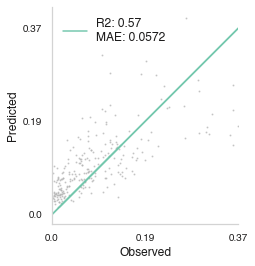

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


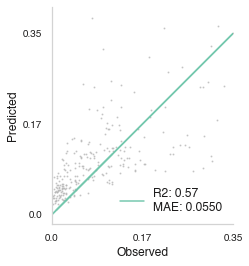

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


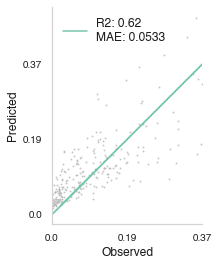

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


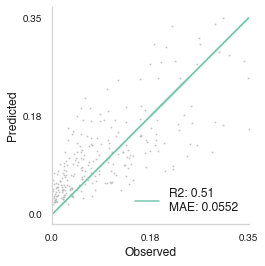

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


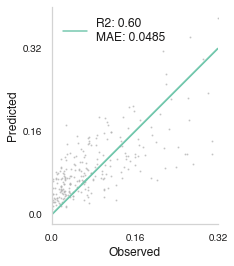

---------- Period 1 err: 0.054 ----------


/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


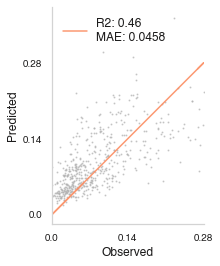

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


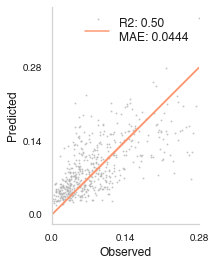

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


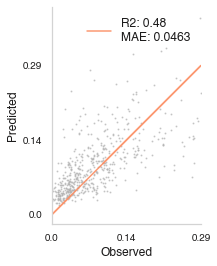

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


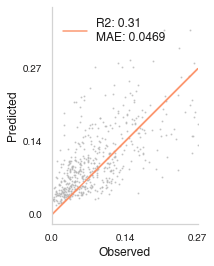

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


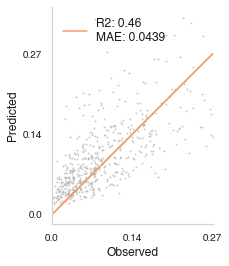

---------- Period 2 err: 0.045 ----------


/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


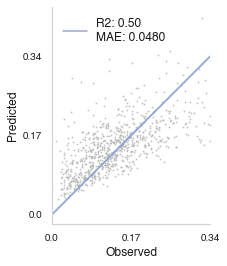

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


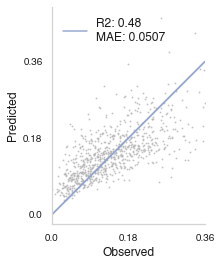

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


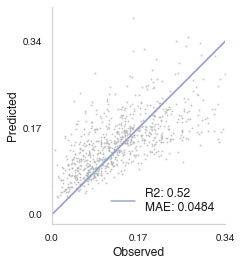

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


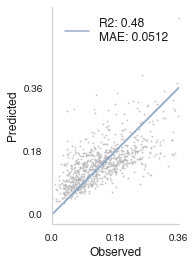

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


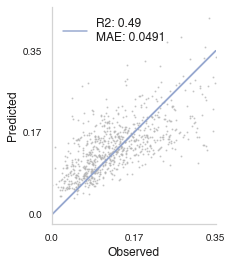

---------- Period 3 err: 0.049 ----------


In [79]:
## Get optimals

# List of all variables
all_vars = ['income', 'political_leaning', 'density', 'crowding', 'dist_to_airport', 'strict',
            'per_nursing', 'per_incar', 'obesity', 'per_wnh', 'per_black', 'per_asian', 'per_other', '19under', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon']

# List to store result
best_params = []
for p in range(1,4):
    # Get period-scaled explanatory variables
    period_vars = ['scaled_'+q+'_p%i'%(p) for q in all_vars]
    vars_to_use = [q for q in period_vars]
    names = [lab_to_string[q[7:-3]] for q in vars_to_use]
    
    # Only add day seeded in period
    if p == 1:
        vars_to_use.append('scaled_start_day_p1')
        names.append('Day seeded')

    # Explanatory and reponse, filtered for seeded counties
    X = reg_df[vars_to_use]
    y = reg_df['rate_%i'%(p)]
    mask = np.array(~np.isnan(y))
    X, y = X[mask], y[mask]
    # Scale y
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    
    # Train/test split and fit to ensure no overfitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)
    params = get_best_model(X_train,y_train)
    oos_err = run_oos(5, params, X, y, p-1)
    print("---------- Period %i err: %.3f ----------" %(p, oos_err))
    best_params.append(params)

#### We'll first establish some helper functions

In [80]:
def plot_importances(ax, importances, names, sds, j, fsize=10, model="", ylab=True, alpha=1):
    '''
    Function to plot a bar plot of importances or coeffs
    
    importances: array of feature importance or coefficients
    names: the plotted names of those features
    sds: standard errors of features
    j: period
    fsize: fontsize on x axis
    model: string of model type
    ylab: boolean of whether to plot y label or not
    alpha: transparency of bars
    '''
    # Sort plots by magnitude of coeff/importance
    x = np.arange(len(names))
    idxs = np.argsort(np.abs([np.sum(q) for q in importances]))
    labels = np.array(names)[idxs]
    width = 0.2  # the width of the bars
    
    # In the spatial model, we want to plot both direct and indirect effects
    if model=='spatial':
        # Add bars. We want to different hatch color and bar outline, so plot those twice
        ax.bar(x, importances[:,1][idxs], label='indirect', color=colors[j], hatch='///', edgecolor='white', zorder=0)
        ax.bar(x, importances[:,1][idxs], label='indirect', color='none', edgecolor='none', zorder=1)
        # Plot direct effects
        ax.bar(x, importances[:,0][idxs], label='direct', bottom=importances[:,1][idxs],
              color=colors[j])
        # Sum impmortances for error bars
        importances = np.sum(importances, axis=1)
        ax.set_ylabel('Coeff', fontproperties=prop, fontsize=11)
    else:
        # Set label
        if model == 'rf' and ylab:
            ax.set_ylabel('Importance', fontproperties=prop, fontsize=11)
        if model != 'rf' and ylab:
            ax.set_ylabel('Coeff', fontproperties=prop, fontsize=11)
        # Plot bars
        barlist = ax.bar(x, importances[idxs], color=colors[j], alpha=alpha, edgecolor='none')
        
    # Plot error bars
    for pos, y, err in zip(x, importances[idxs], np.array(sds)[idxs]):
        ax.errorbar(pos, y, err, capsize=3, elinewidth=1.2, markeredgewidth=1.2, ecolor='dimgrey', alpha=0.5)
        
    # Set ticks and clean plot
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontproperties=prop, fontsize=fsize, rotation=90)
    ax.set_yticklabels([round(q, 2) for q in ax.get_yticks()], fontproperties=prop, fontsize=8)
    sns.despine(left=True, bottom=True, top=True, right=True)
    
    
def plot_network_colorbar(ax, cmap):
    '''
    Saves the colorbar for network plots as a separate figure 
    '''
    sm = mpl.cm.ScalarMappable(cmap=cmap)
    cbar_ax = inset_locator.inset_axes(ax,
                width="5%",  # width = 50% of parent_bbox width
                height="40%",  # height : 5%,
                bbox_to_anchor=(1, 0.4, 1, 1),
                bbox_transform=ax.transAxes,
                loc='lower left')
    cbar = f.colorbar(sm, cax=cbar_ax)
    cbar.set_ticks([0, 0.5,1])
    cbar.set_ticklabels([-1, 0, 1])
    for t in cbar_ax.yaxis.majorTicks:
        t.label1.set_fontproperties(prop)
        t.label1.set_fontsize(8)
        
        
def network_plot(period_vars, names, period, mask=[], maskuse=False, colorbar=False, fname=""):
    '''
    Plot correlation network, as in the subplots of Figure 3.7.
    Function inspired by https://www.python-graph-gallery.com/327-network-from-correlation-matrix
    
    period_vars: column names to include
    names: plotted names of those columns
    period: the period number
    mask: list of what rows to include
    maskuse: if the variables include mask use
    colorbar: boolean to include colorbar
    fname: name of file ot save to
    '''
    # Filter to desired data
    if len(mask) == 0:
        mask = np.repeat(True, len(reg_df))
    pair_data = reg_df[period_vars][mask]
    
    # Rename columns
    rename_cols = {}
    for i in range(len(period_vars)):
        rename_cols[period_vars[i]] = names[i]
    pair_data = pair_data.rename(columns=rename_cols)
    
    
    # Calculate the correlation between individuals. We have to transpose first
    # because the corr function calculate the pairwise correlations between columns.
    corr = pair_data.corr(method='spearman')

    # Transform it in a links data frame (3 columns only):
    links = corr.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']

    # Keep only correlation over 0.5 and remove self correlation (cor(A,A)=1)
    links_filtered=links.loc[ (np.abs(links['value']) > 0.5) & (links['var1'] != links['var2']) ]
    
    # Set colormap and colors
    cmap = mpl.cm.get_cmap('coolwarm', 20)
    e_colors = list(map(lambda x: cmap((x+1)/2), links_filtered.value.values))

    # Build graph
    G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', 'value')
    
    # Creates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'value').items())
    
    # Set layout
    pos = nx.spring_layout(G, k=0.5)
    
    # Plot
    f = plt.figure(figsize=(6,6))
    ax = f.add_subplot(111)
    if period == 1:
        plt.title("Static Variable Correlations", fontproperties=prop, fontsize=14)
    elif maskuse:
        plt.title("Correlations Between Counties with Mask Use Data", fontproperties=prop, fontsize=14)
    else:
        plt.title("Correlations Period %i"%(period), fontproperties=prop, fontsize=14)
    
    # Draw notes and edges
    nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightgray', node_size=600, linewidths=3, font_size=11)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=np.array(weights)/2+0.5, edge_cmap=cmap, width=3)
    
    # Plot colorbar
    if colorbar:
        plot_network_colorbar(ax, cmap)
    
    # Save to file
    if fname != "":
        plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    
def filter_coeffs(coeffs, names, errs):
    '''
    Function to filter coefficients, plotted names, and standard errors. Always remove coefficients that are 0 and Lat/Lon
    '''
    # List of names to exclude and coefficients to exclude
    names_exclude = ['Lat', 'Lon']
    coeffs_exclude = [0]
    # Variables to store filtered lists
    plot_coeffs, plot_names, plot_errs = [], [], []
    # Perform filtering
    for i in range(len(coeffs)):
        if coeffs[i] not in coeffs_exclude and names[i] not in names_exclude:
            plot_coeffs.append(coeffs[i])
            plot_names.append(names[i])
            plot_errs.append(errs[i])
    return plot_coeffs, plot_names, plot_errs

#### Establish seeding model

In [90]:
def predict_seeded(X, y, penalty='none'):
    '''
    Perform a logisitic regression given explanatory variables X and response variable y
    
    Penalty: either none or l1
    
    Returns the coefficients, standard errors of coefficients, and predicted y values
    '''
    X = add_constant(X)
    y = y.reshape(-1,1)
    lr = sm.Logit(y, X)
    # Perform the regression with regularization
    if penalty == 'l1':
        print("Adding regularization")
        # Find model with optimal AIC
        opt_aic, opt_alpha = np.inf, 0
        for a in np.arange(0.01, 1, 0.01):
            lr = sm.Logit(y, X)
            lr = lr.fit_regularized(alpha=a, method='l1', max_iter=10**6, restol=10**4, disp=False)
            if lr.aic < opt_aic:
                opt_aic, opt_alpha = lr.aic, a
        print("optimal alpha, aic", opt_alpha, opt_aic)
        # Fit final model with optimal alpha
        lr = sm.Logit(y, X)
        lr = lr.fit_regularized(alpha=opt_alpha)
    # Otherwise add no regularization
    else:
        lr = lr.fit()
        
    # Save output to get standard errors
    output = lr.summary()
    results_as_html = output.tables[1].as_html()
    df_lr = pd.read_html(results_as_html, header=0, index_col=0)[0]

    return list(df_lr.coef.values)[1:], list(df_lr['std err'].values)[1:], [round(q) for q in lr.predict(X)]

def print_stats(cmat):
    '''
    Print accuracy, sensitivity, and specificity givena confusion matrix
    '''
    print("Confusion matrix\n", cmat)
    print("Accuracy %.3f" %(np.sum(np.diag(cmat))/np.sum(cmat)))
    print("Sens", cmat[0,0]/(cmat[0,0]+cmat[1,0]))
    print("Spec", cmat[1,1]/(cmat[0,1]+cmat[1,1]))
    return

def run_seeded(all_vars, period, show_l1=False, file_suffix=""):
    '''
    Run logisitic regression given a set of variables and a period
    '''
    file_loc = '../figures/chapter_3/hypothesis_testing/P%i/'%(period)
    # Get the scaled and transformed variables for that period
    include_vars = ['scaled_'+q+"_p%i"%(period) for q in all_vars]
    # Plotted names of variables
    names = [lab_to_string[q] for q in all_vars]
    
    # Construct a correlation plot
    network_plot(include_vars, names, period, fname=file_loc+'corr_network.svg')
    
    # Set up explanatory and response variables
    X = reg_df[include_vars]
    y = (reg_df.period_seeded.values == period).astype(int)
    print("Condition number", np.linalg.cond(X))
    
    for i in range(2):
        if i == 0:
            # No regularization
            coeffs, errs, pred = predict_seeded(X,y)
            save_name = 'logit_noreg'+file_suffix
        elif show_l1:
            # No regularization
            coeffs, errs, pred = predict_seeded(X,y,penalty='l1')
            save_name = 'logit_l1'+file_suffix
        else:
            continue
            
        # Show results in an confusion matrix
        cmat = confusion_matrix(y, pred) 
        print_stats(cmat)

        # Filter coefficients
        pcoeff, pnames, perrs = filter_coeffs(coeffs, names, errs)

        # Plot coeffients
        f, ax = plt.subplots(nrows=1, ncols=1)
        plot_importances(ax, np.array(pcoeff), pnames, perrs, period-1,
                         fsize=10, ylab=True, alpha=0.6)
        plt.savefig(file_loc+'%s.svg'%(save_name), bbox_inches='tight', dpi=300)
        plt.show()
    

#### Establish spreading models

In [94]:
def get_weights(mask, weight='knn', k=5):
    '''
    Returns weights for spatial lag model
    
    mask: rows excluded
    weight: weight type
    k: value for k nearest-neighbors weight matrix
    '''
    # Contruct geometric dataframe for libpysal
    geom = [Point(xy) for xy in zip(reg_df.lon, reg_df.lat)]
    gdf = gpd.GeoDataFrame(reg_df, crs="EPSG:4326", geometry=geom).drop(["lon", "lat"], axis=1).reset_index()
    # Get weight matrix
    m_df = gdf[mask].reset_index()
    # Choose weight matrix type
    if weight == 'knn':
        print('here')
        w = libpysal.weights.KNN.from_dataframe(m_df, k=k)
    elif weight == 'kernel':
        w = libpysal.weights.Kernel.from_dataframe(m_df, k=k)
    
    # Set diagnol to zero
    for k in range(m_df.shape[0]):
        if k in w.neighbors[k]:
            idx = w.neighbors[k].index(k)
            w.weights[k][idx]=0.0
    w.transform = 'r'
    
    return w

def run_mult_spatial(X, y, w):
    '''
    Run a spatial lag model given explanatory and response variables and weight matrix
    
    Returns a list of direct and indirect effects, standard errors, predictions, and true values
    '''
    lag=ML_Lag(y,X,w=w)
        
    # Get both direct and indirect effects
    b=lag.betas[:-1]
    rho=lag.betas[-1]
    btot=b/(float(1)-rho)
    bind=btot-b
    
    return list(zip(list([q[0] for q in b[1:]]), list([q[0] for q in bind[1:]]))), lag.std_err, lag.predy, y

def run_rf(X, y, params):
    '''
    Runs a RF model given the optimal set of parameters
    
    Returns the importances, standard deviation of importances, predicitions, and true values
    '''
    # Establish model
    model = RandomForestRegressor(random_state=18, **params) 
    # Fit
    model.fit(X,y)
    # Calculate feature importance using permutation importance
    imp = permutation_importance(model, X, y, n_repeats=10)
    return imp.importances_mean, imp.importances_std, model.predict(X), y


# Weight code: 
# https://stackoverflow.com/questions/58874333/how-can-i-weigh-the-observations-for-lasso-regression-in-following-python-code
def lasso_mult(X, y, w):
    '''
    Runs a weighted LASSO regression based on weights w
    
    Returns coefficients, standard error of coefficients, predictions, and true values
    '''
    # Create our weights matrix (log of population)
    W = np.diag(np.log10(w))
    
    # Create an intercept column
    n_rows, n_cols = np.shape(X)
    X_intercept = np.append(X, np.ones([n_rows, 1]),axis=1)
    
    # Transform the variables according to weights
    X_trans = np.dot(W, X_intercept)
    y_trans = np.dot(W, y)
    
    # Establish LASSO CV model
    cv = RepeatedKFold(n_splits=5, n_repeats=10)
    model = LassoCV(alphas=np.arange(0.01, 1, 0.1), max_iter=10**6, cv=cv, fit_intercept=False, random_state=18, n_jobs=-1)
    
    # Fit and predict
    model.fit(X_trans,y_trans)
    y_pred = model.predict(X_trans)
    y_pred = np.linalg.inv(W)@y_pred
    
    
    # Compute standard errors
    ## https://stackoverflow.com/questions/22381497/python-scikit-learn-linear-model-parameter-standard-error
    residuals = y - y_pred
    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares / (X_intercept.shape[0] - X_intercept.shape[1])
    var_beta_hat = np.linalg.inv(X_intercept.T @ X_intercept) * sigma_squared_hat
    std_errs = np.sqrt(np.diag(var_beta_hat))

    return list(model.coef_)[:-1], std_errs, y_pred, y

def get_model_results(iter_val, X, y, v, mask):
    if iter_val == 0:
        print("--- Running Spatial Model ---")
        w = get_weights(mask, k=5)
        coeffs, errs, y_pred, y_true = run_mult_spatial(X, np.array(y).reshape((-1,1)), w)
        model = 'spatial'
    elif iter_val == 1:
        print("--- Running Random Forest ---")
        coeffs, errs, y_pred, y_true = run_rf(X, y, best_params[period-1])
        model = 'rf'
    elif iter_val == 2:
        print("--- Running LASSO ---")
        coeffs, errs, y_pred, y_true = lasso_mult(X, y, reg_df.Population[mask])
        model = 'lasso'
    return coeffs, errs, y_pred, y_true, model

def run_spreading(all_vars, period, filter_no_mask=False, use_mask=False, file_suffix=""):
    '''
    Run the three spreading models given a set of variables and a period
    '''
    file_loc = '../figures/chapter_3/hypothesis_testing/P%i/'%(period)
    # Get the scaled and transformed variables for that period
    include_vars = ['scaled_'+q+"_p%i"%(period) for q in all_vars]
    # Plotted names of variables
    names = [lab_to_string[q] for q in all_vars]
    
    # Add mask data if desired
    if use_mask:
        include_vars.append('scaled_public_mask_usage_p3')
        names.append('Mask Use')
    
    # Explanatory and reponse, filtered for seeded counties
    v = 'rate_%i_scaled'%(period)
    X = reg_df[include_vars]
    y = reg_df[v]
    
    # Filter
    if filter_no_mask:
        mask = np.array(~np.isnan(y.values)) & (~np.isnan(X['scaled_public_mask_usage_p3'].values))
    else:
        mask = np.array(~np.isnan(y.values))
    X, y = X[mask].values, y[mask].values
    
    # Construct a correlation plot
    network_plot(include_vars, names, period, mask=mask, maskuse=filter_no_mask, 
                 colorbar=False, fname=file_loc+'corr_network_spread.svg')
    
    # Calculate condition number and scale y
    print('Condition number', np.linalg.cond(X))
    y = (y-np.min(y)) / (np.max(y)-np.min(y))
    
    for i in range(3):
        coeffs, errs, y_pred, y_true, model = get_model_results(i, X, y, v, mask)
        pcoeff, pnames, perrs = filter_coeffs(coeffs, names, errs)
        
        # Plot fit
        f = plt.figure(figsize=set_size(312))
        ax = f.add_subplot(111)
        plot_scatter(ax, y_true, y_pred, period-1)
        plt.savefig(file_loc+'%s_scatter_%s'%(model, file_suffix), bbox_inches='tight', dpi=300)
        plt.show()

        # Plot importances
        f = plt.figure(figsize=set_size(312))
        ax = f.add_subplot(111)
        plot_importances(ax, np.array(pcoeff), pnames, perrs, period-1, fsize=9, model=model)
        plt.savefig(file_loc+'%s_coeff_%s'%(model, file_suffix), bbox_inches='tight', dpi=300)
        plt.show()
        
    
    
    


### Period 1 Seeding

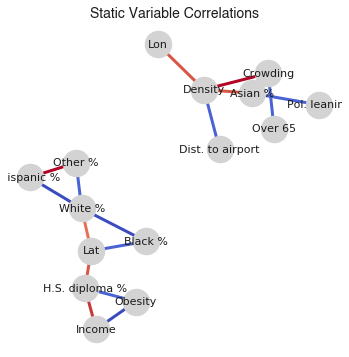

Condition number 133.98596002284685
Optimization terminated successfully.
         Current function value: 0.350026
         Iterations 8
Confusion matrix
 [[1932  136]
 [ 296  558]]
Accuracy 0.852
Sens 0.8671454219030521
Spec 0.8040345821325648


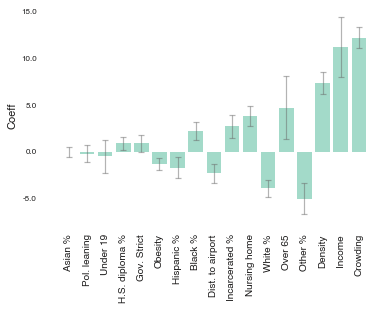

In [92]:
# Variables to include. Can toggle between sets of variables and change filename
all_vars = ['crowding', 'density', 'per_asian', 'per_other', 'income', 'political_leaning',
             'dist_to_airport', 'strict', '19under', 'per_wnh', 'obesity',
            'per_nursing', 'per_incar', 'per_black', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon']
# all_vars= ['crowding', 'income', 'political_leaning',
#              'dist_to_airport','strict', 'obesity',
#             'per_nursing', 'per_incar', 'per_black', '65plus',
#             'per_atleast_hs',  'per_hispanic', 'lat', 'lon']

run_seeded(all_vars, 1, file_suffix="")

### Period 1 Spread

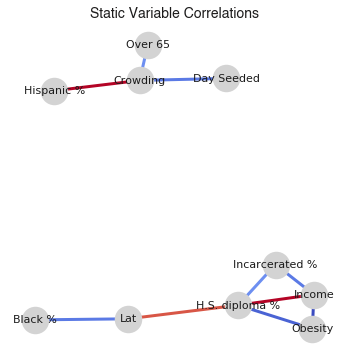

Condition number 201.32974797815172
--- Running Spatial Model ---
here


/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


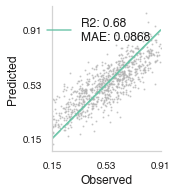

<Figure size 432x288 with 0 Axes>

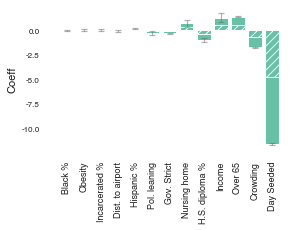

--- Running Random Forest ---


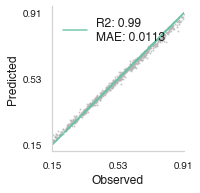

<Figure size 432x288 with 0 Axes>

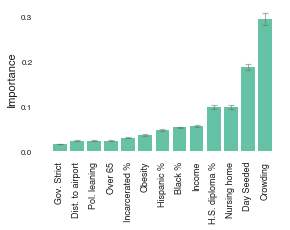

--- Running LASSO ---


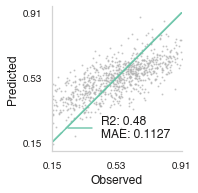

<Figure size 432x288 with 0 Axes>

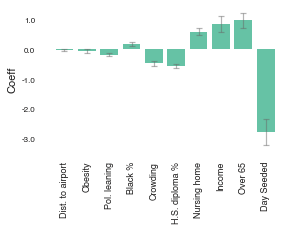

In [95]:
all_vars = ['crowding', 'density', 'per_asian', 'per_other', 'income', 'political_leaning',
             'dist_to_airport', 'strict', '19under', 'per_wnh', 'obesity',
            'per_nursing', 'per_incar', 'per_black', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon']
all_vars = ['income', 'political_leaning',  'crowding',
             'dist_to_airport', 'strict', 'start_day',
            'per_nursing', 'per_incar', 'obesity',  'per_black', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon', ]
run_spreading(all_vars, 1, filter_no_mask=False, file_suffix="now.pdf")

### Period 2 Seeding

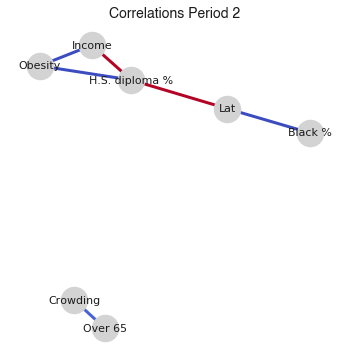

Condition number 55.22045245752546
Optimization terminated successfully.
         Current function value: 0.583318
         Iterations 6
Confusion matrix
 [[1740  215]
 [ 695  272]]
Accuracy 0.689
Sens 0.7145790554414785
Spec 0.5585215605749486


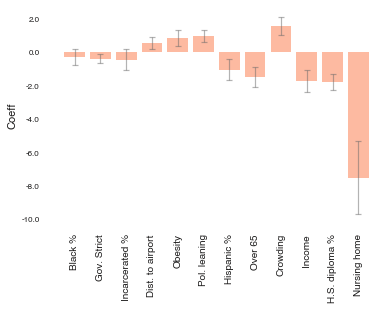

In [96]:
# Variables to include. Can toggle between sets of variables and change filename
# all_vars = ['crowding', 'density', 'per_asian', 'per_other', 'income', 'political_leaning',
#              'dist_to_airport', 'strict', '19under', 'per_wnh', 'obesity',
#             'per_nursing', 'per_incar', 'per_black', '65plus',
#             'per_atleast_hs',  'per_hispanic', 'lat', 'lon']
all_vars= ['crowding', 'income', 'political_leaning',
             'dist_to_airport','strict', 'obesity',
            'per_nursing', 'per_incar', 'per_black', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon']

run_seeded(all_vars, 2, file_suffix="")

### Period 2 Spread

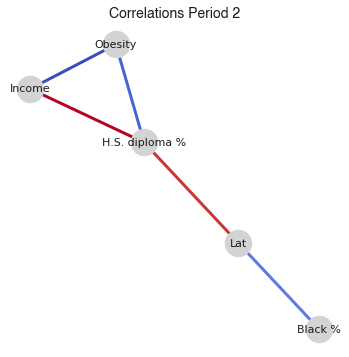

Condition number 119.35422895111874
--- Running Spatial Model ---
here


/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


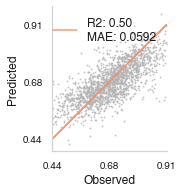

<Figure size 432x288 with 0 Axes>

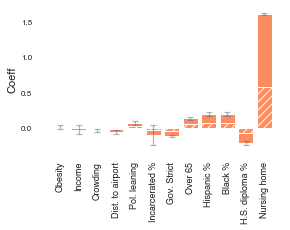

--- Running Random Forest ---


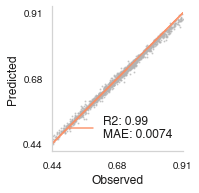

<Figure size 432x288 with 0 Axes>

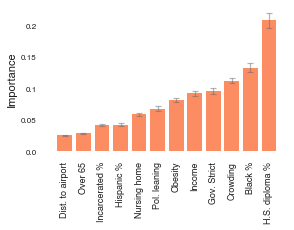

--- Running LASSO ---


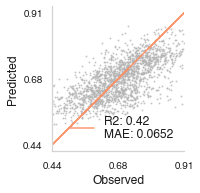

<Figure size 432x288 with 0 Axes>

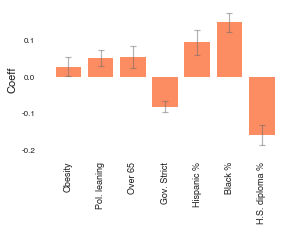

In [98]:
all_vars = ['crowding', 'density', 'per_asian', 'per_other', 'income', 'political_leaning',
             'dist_to_airport', 'strict', '19under', 'per_wnh', 'obesity',
            'per_nursing', 'per_incar', 'per_black', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon']
all_vars = ['income', 'political_leaning',  'crowding',
             'dist_to_airport', 'strict',
            'per_nursing', 'per_incar', 'obesity',  'per_black', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon', ]
run_spreading(all_vars, 2, filter_no_mask=False, file_suffix="p2.svg")

### Period 3 Spread

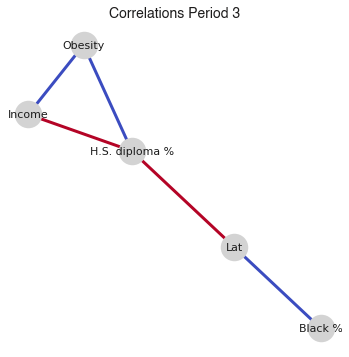

Condition number 58.19606982137523
--- Running Spatial Model ---
here


/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


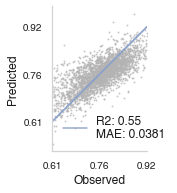

<Figure size 432x288 with 0 Axes>

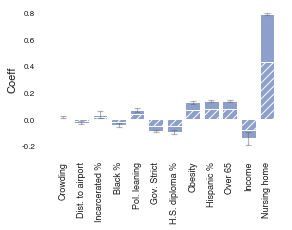

--- Running Random Forest ---


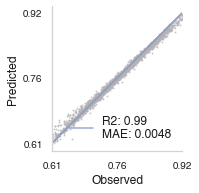

<Figure size 432x288 with 0 Axes>

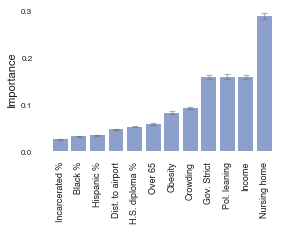

--- Running LASSO ---


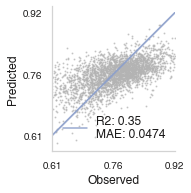

<Figure size 432x288 with 0 Axes>

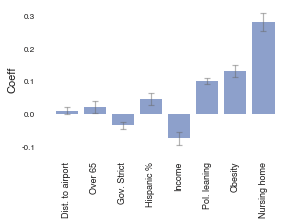

In [99]:
# Once without mask use
all_vars = ['crowding', 'density', 'per_asian', 'per_other', 'income', 'political_leaning',
             'dist_to_airport', 'strict', '19under', 'per_wnh', 'obesity',
            'per_nursing', 'per_incar', 'per_black', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon']
all_vars = ['income', 'political_leaning',  'crowding',
             'dist_to_airport', 'strict',
            'per_nursing', 'per_incar', 'obesity',  'per_black', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon', ]
run_spreading(all_vars, 3, filter_no_mask=False, file_suffix="p3.svg")

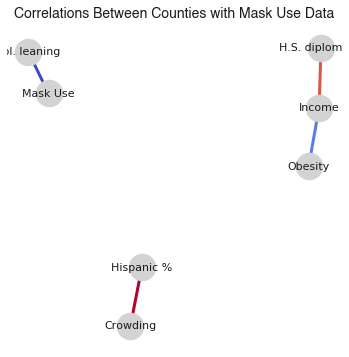

Condition number 137.0162116111916
--- Running Spatial Model ---
here


/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


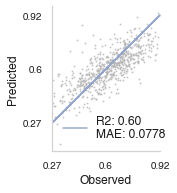

<Figure size 432x288 with 0 Axes>

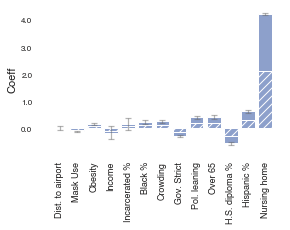

--- Running Random Forest ---


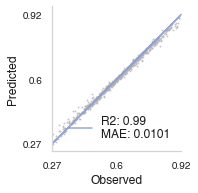

<Figure size 432x288 with 0 Axes>

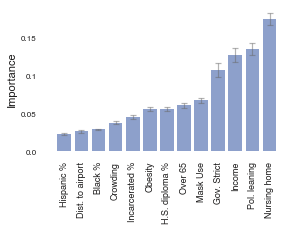

--- Running LASSO ---


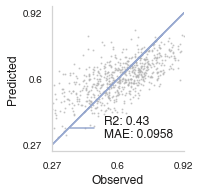

<Figure size 432x288 with 0 Axes>

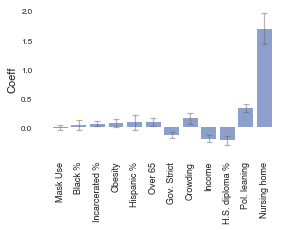

In [100]:
# And with mask use
all_vars = ['crowding', 'density', 'per_asian', 'per_other', 'income', 'political_leaning',
             'dist_to_airport', 'strict', '19under', 'per_wnh', 'obesity',
            'per_nursing', 'per_incar', 'per_black', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon']
all_vars = ['income', 'political_leaning',  'crowding',
             'dist_to_airport', 'strict',
            'per_nursing', 'per_incar', 'obesity',  'per_black', '65plus',
            'per_atleast_hs',  'per_hispanic', 'lat', 'lon', ]
run_spreading(all_vars, 3, filter_no_mask=True, use_mask=True, file_suffix="maskuse.svg")

## Section 6: Mapping

Three maps: one for seeded/unseeded, one for death rates, and one for variables figure

In [101]:
# Read in shapefile of counties, states, and regions to prepare for plotting
county_shp = gpd.read_file('../shapefiles/cb_2018_us_county_20m.shp')
state_shp = gpd.read_file('../shapefiles/cb_2018_us_state_20m.shp')
region_shp = gpd.read_file('../shapefiles/cb_2018_us_region_20m.shp')
# Construct a column of fips ids 
county_shp['fips'] = [str(county_shp.STATEFP.values[i]) + str(county_shp.COUNTYFP.values[i]) for i in range(len(county_shp))]
county_shp.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,fips
0,37,017,01026336,0500000US37017,37017,Bladen,06,2265887723,33010866,"POLYGON ((-78.90200 34.83527, -78.79960 34.850...",37017
1,37,167,01025844,0500000US37167,37167,Stanly,06,1023370459,25242751,"POLYGON ((-80.49737 35.20210, -80.29542 35.502...",37167
2,39,153,01074088,0500000US39153,39153,Summit,06,1069181981,18958267,"POLYGON ((-81.68699 41.13596, -81.68495 41.277...",39153
3,42,113,01213687,0500000US42113,42113,Sullivan,06,1165338428,6617028,"POLYGON ((-76.81373 41.59003, -76.22014 41.541...",42113
4,48,459,01384015,0500000US48459,48459,Upshur,06,1509910100,24878888,"POLYGON ((-95.15274 32.66095, -95.15211 32.902...",48459


In [102]:
# Add matching fips column to our dataframe, which is needed for the following function
reg_df['fips'] = reg_df['FIPS'].astype(int).astype(str)
# Add leading zeros
reg_df['fips'] = [x.zfill(5) for x in reg_df.fips]
# Add matching fips column to our dataframe, which is needed for the following function
df['fips'] = df['FIPS'].astype(int).astype(str)
# Add leading zeros
df['fips'] = [x.zfill(5) for x in df.fips] 
df.head()

,FIPS,Province_State,Admin2,Lat,Long_,Population,1/28/20,1/29/20,1/30/20,1/31/20,...,strict_p1,strict_p2,strict_p3,strict_p1_bucket,strict_p2_bucket,strict_p3_bucket,Enplanements,dist_to_airport,public_mask_usage_p3,fips
0,1001.0,Alabama,Autauga,32.539527,-86.644082,55869,0.0,0.0,0.0,0.0,...,52.743684,38.140236,29.454882,strict,loose,loose,no airport,152.861623,NaN,01001
1,1003.0,Alabama,Baldwin,30.727750,-87.722071,223234,0.0,0.0,0.0,0.0,...,52.743684,38.140236,29.454882,strict,loose,loose,no airport,157.966295,79.557943,01003
2,1005.0,Alabama,Barbour,31.868263,-85.387129,24686,0.0,0.0,0.0,0.0,...,52.743684,38.140236,29.454882,strict,loose,loose,no airport,143.242244,NaN,01005
3,1007.0,Alabama,Bibb,32.996421,-87.125115,22394,0.0,0.0,0.0,0.0,...,52.743684,38.140236,29.454882,strict,loose,loose,no airport,162.982182,NaN,01007
4,1009.0,Alabama,Blount,33.982109,-86.567906,57826,0.0,0.0,0.0,0.0,...,52.743684,38.140236,29.454882,strict,loose,loose,no airport,121.344346,NaN,01009


In [103]:
# Colors for categorical maps
cluster_colors = ['#c90cc6', '#091091','#fdc086']
seed_colors = [ '#029e73', '#d55e00', '#8172b3']

In [104]:
## Mapping functions

def get_var_color_map(met, n_levels):
    '''
    Get continuous color maps based on variable we are plotting
    '''
    if met == 'political_leaning':
        cmap = mpl.cm.get_cmap('coolwarm', n_levels+1)
    elif met == 'pop_density':
        cmap = mpl.cm.get_cmap('Purples', n_levels+1)
    elif met == 'median_household_income':
        cmap = mpl.cm.get_cmap('Blues', n_levels+1)
    elif met == 'per_poc' or 'rate' in met:
        cmap = mpl.cm.get_cmap('Oranges', n_levels+1)
    elif met == 'crowding':
         cmap = mpl.cm.get_cmap('Greens', n_levels+1)
    elif met == 'public_mask_usage_p3':
         cmap = mpl.cm.get_cmap('gist_earth_r', n_levels+1)
    colors = [str(mpl.colors.rgb2hex(cmap(q))) for q in range(5, cmap.N)]
    
    if 'rate' in met:
        cmap = mpl.cm.get_cmap('inferno', n_levels+1)
        colors = [str(mpl.colors.rgb2hex(cmap(q))) for q in range(cmap.N-2)][::-1]
        
    return cmap, colors

def add_county_geometries_variables(ax, counties, cmap, categorical=False):
    '''
    Add all counties in a given state
    '''
    for i in range(len(counties)):
        county = counties.iloc[i]
        if categorical:
            c = county.phase
        else:
            if county.phase < 0:
                c = 'lightgray'
            else:
                c = cmap(county.phase)
        if pd.isnull(county.phase):
            c = 'white'
        ax.add_geometries([county.geometry], 
                          crs=ccrs.PlateCarree(), 
                          facecolor=c, # add color based on vec
                          edgecolor=c)
        
# A function that draws inset map for Alaska and Hawaii 
## https://stackoverflow.com/questions/55598249/showing-alaska-and-hawaii-in-cartopy-map
def add_insetmap(axes_extent, map_extent, state_geo, state_counties, cmap, categorical, region):
    '''
    Add another axes to a map for Hawaii and Alaska
    '''
    # create new axes, set its projection
    use_projection = ccrs.Mercator()     # preserve shape well
    sub_ax = plt.axes(axes_extent, projection=use_projection)  # normal units
    sub_ax.set_extent(map_extent)  # map extents

    # add map `geometry` here
    add_county_geometries_variables(sub_ax, state_counties, cmap, categorical)
    sub_ax.add_geometries([state_geo], facecolor='none',  edgecolor='black', lw=0.2+1.3*region, crs=ccrs.PlateCarree())
    sub_ax.axis('off')
    
def set_color_limits(met, vec, n_levels=15, lims=[]):
    '''
    Function to set the color limits based on quantiles so that each color has the same number of counties.
    This avoids outliers having too big an impact on the plot
    '''
    # Scale vector to be between 0 and 1
    small, large = np.nanmin(vec), np.nanmax(vec)
    vec = (vec - small) / (large-small)
    
    # Case when we're not using preset limits
    if len(lims) == 0:
        # Quantile
        buckets = np.unique(pd.qcut(vec, q=n_levels).astype(str))
        buckets = buckets[buckets != 'nan']

        # Sort and ensure that the limits include 0 and 1
        lims =  np.sort([float(q[1:q.find(',')]) for q in buckets])
        lims[0] = 0
        lims = np.append(lims,1)
        
        
    # Get original values
    original_vals = [round(q, 4) for q in lims * (large-small) + small]
    
    # For rate variables, we want anything not seeded to be a different color
    if 'rate' in met:        
        if met == 'rate_2':
            vec[~(reg_df.period_seeded <= 2)] = -1
        elif met == 'rate_3':
            vec[np.isnan(reg_df.period_seeded)] = -1
        
    # Now get the colormap
    cmap, colors = get_var_color_map(met, n_levels+2+3*('rate' not in met))
    cmap_2, norm = [], []
    
    # We want to keep the original mapping for political lean
    if met != 'political_leaning':
        mapping = list(zip(lims, colors))
        cmap = mpl.colors.LinearSegmentedColormap.from_list('custom_map', mapping)
        cmap_2, norm = mpl.colors.from_levels_and_colors(lims, colors[:-1])
    return cmap, cmap_2, norm, lims, original_vals, vec

def get_colorbar_labels(met, original_vals):
    '''
    Sets a different label for median household income
    '''
    if met == 'median_household_income':
        labs = [str(int(round(q/1000, 0)))+'K' for q in original_vals]
    elif met == 'political_leaning':
        labs = ['Strong Dem.', 'Strong Rep.']
    else:
        labs = ['%.2f'%(q) for q in original_vals]
    return labs
        
def add_colorbar(fig, ax, cmap, cmap_2, norm, met, lims, original_vals):
    '''
    Function to add the colorbar based on the current colormap
    '''
    pos = ax.get_position()
    
    # We didn't end up scaling the colormap for political leaning
    if met == 'political_leaning':
        sm = mpl.cm.ScalarMappable(cmap=cmap)
    else:
        sm = mpl.cm.ScalarMappable(cmap=cmap_2, norm=norm)
        
    # Add an inset axes
    axins1 = inset_locator.inset_axes(ax,
                width="95%",  
                height="5%", 
                bbox_to_anchor=(0, -0.17, 1, 1),
                bbox_transform=ax_map.transAxes,
                loc='lower left')
    
    # Add colorbar
    cbar = fig.colorbar(sm, cax=axins1, ticks=lims, orientation='horizontal')
    
    # Set labels 
    labs = get_colorbar_labels(met, original_vals)
    cbar.set_ticks(lims[::2])
    cbar.set_ticklabels(labs[::2])
    if m == 'political_leaning':
        cbar.set_ticks([lims[0] + 0.03, lims[-1] - 0.04])
        cbar.set_ticklabels(labs)
        
    # Remove outline on colorbar
    cbar.outline.set_linewidth(0.5)
    
    # Set fontsize and properties
    for t in axins1.xaxis.majorTicks:
        t.label1.set_fontproperties(prop)
        t.label1.set_fontsize(8)
        
        
def plot_vector_on_map(fig, ax, vec, met, df_to_use, preset_lims=[], categorical=False, colorbar=False, regions=False):
    '''
    Function to plot a vector, vec, on a map of the United States using the given matplotlib axis
    '''
    plot_df = df_to_use[['fips']].copy()
    if categorical:
        cmap = []
    if not categorical:
        cmap, cmap_2, norm, lims, original_vals, vec = set_color_limits(met, vec, 
                                                                        n_levels=10+5*('rate' not in met), lims=preset_lims)
    plot_df['phase'] = vec
    
    # Merge onto shapefile of county shapes
    plot_county = county_shp.merge(plot_df, on='fips', how='left') 
    # Establish counties, states, and regions
    counties = list(county_shp.geometry.values)
    states = list(state_shp.geometry.values)
    
    for i in range(len(state_shp)):
        state = state_shp.iloc[i]
        state_num = state.STATEFP
        # Add inset for Alaska
        if  state_num == '02':
            map_extent = (-178, -128, 49, 71)   
            axes_extent = (0.13, 0.19, 0.24, 0.21)
            add_insetmap(axes_extent, map_extent, state.geometry, plot_county[plot_county.STATEFP == state_num], 
                         cmap, categorical, regions)
        # Add inset for Hawaii
        elif state_num == '15':
            map_extent = (-159, -154, 18.5, 22)
            if regions:
                axes_extent = (0.31, 0.25, 0.1, 0.1)
            else:
                axes_extent = (0.29, 0.22, 0.1, 0.1)
            add_insetmap(axes_extent, map_extent, state.geometry, plot_county[plot_county.STATEFP == state_num], 
                         cmap, categorical, regions)
        # The other states
        else:
            add_county_geometries_variables(ax, plot_county[plot_county.STATEFP == state_num], cmap, categorical)
            ax.add_geometries([state.geometry], facecolor='none', edgecolor='black', lw=0.2, alpha=0.5, crs=ccrs.PlateCarree())
    
    # Plot regions
    if regions:
        regions = list(region_shp.geometry.values) 
        REGIONS = cfeature.ShapelyFeature(regions, ccrs.PlateCarree())
        ax.add_feature(REGIONS, facecolor='none', edgecolor='black', lw=1.5)
    
    # Add colorbar to bottom of map
    if colorbar:
        add_colorbar(fig, ax, cmap, cmap_2, norm, met, lims, original_vals)
        
    ax.set_extent([-125, -66.8, 22, 48])
    
    # Turn off the axes for a cleaner plot
    ax.axis('off')
    
    return
        

#### Presence of COVID-19 maps in Figure 3.1

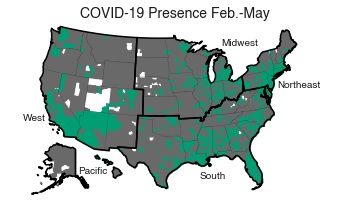

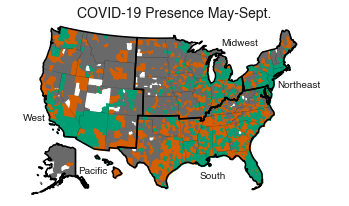

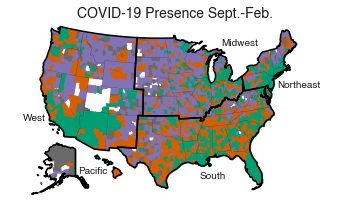

In [117]:
# Title
labels = ['Feb.-May', 'May-Sept.', 'Sept.-Feb.']

for i in range(0, 3):
    # Get days seeded
    starts = df.start_day.values
    
    # Vector to store period seeded
    vec = np.copy(starts) 
    
    #  Period 1: only counties seeded in period 1 are colored, everything else is gray. Note that starts < 0 are counties
    # that are never seeded
    vec[(starts < split_1) & (starts > 0)] = 0
    if i == 0:
        vec[~((starts < split_1) & (starts > 0))] = -1
    # Period 2: counties in period 1 and 2 are colored
    elif i == 1:
        vec[(starts >= split_1) & (starts < split_2)] = 1
        vec[(starts >= split_2) | (starts < 0)] = -1
    # Period 3: the only counties not colored are the ones that are never seeded
    elif i == 2:
        vec[(starts >= split_1) & (starts < split_2)] = 1
        vec[(starts >= split_2)] = 2
        vec[(starts <= 0)] = -1
        
    # Convert integers to colors
    phases = [seed_colors[q] if q >= 0 else 'dimgray' for q in vec]
    
    # Plot
    fig = plt.figure()
    ax_map = fig.add_subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-98.58, central_latitude=39.83))
    plot_vector_on_map(fig, ax_map, phases, 'seeded', df, categorical=True, colorbar=False, regions=True)
    ax_map.set_title("COVID-19 Presence %s"%(labels[i]), fontproperties=prop, fontsize=14)
    
    # Add region labels
    plt.text(0.57, 0.26, 'South', fontproperties=prop, fontsize=10, transform=plt.gcf().transFigure)
    plt.text(0.75, 0.575, 'Northeast', fontproperties=prop, fontsize=10, transform=plt.gcf().transFigure)
    plt.text(0.16, 0.46, 'West', fontproperties=prop, fontsize=10, transform=plt.gcf().transFigure)
    plt.text(0.62, 0.72, 'Midwest', fontproperties=prop, fontsize=10, transform=plt.gcf().transFigure)
    plt.text(0.29, 0.275, 'Pacific', fontproperties=prop, fontsize=10, transform=plt.gcf().transFigure)
    
    # Save
    plt.savefig("../figures/chapter_3/figure_3_1/seeded_map_p%i.svg"%(i+1), bbox_inches='tight')
    plt.show()

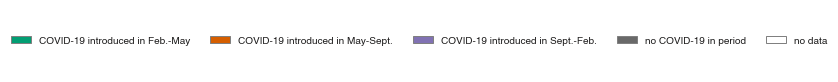

In [122]:
# Separate legend for the above plots
fig = plt.figure(figsize=(2, 1.25))
labels_leg = ['COVID-19 introduced in '+ q for q in labels] + ['no COVID-19 in period', 'no data']
cs = seed_colors + ['dimgray', 'white']
patches = [
    mpl.patches.Patch(facecolor=c, label=l, edgecolor='gray')
    for l, c in zip(labels_leg, cs)]
plt.plot() # Empty plot
plt.xticks([])
plt.yticks([])
prop.set_size(10)
fig.legend(patches, labels_leg, loc='center', frameon=False, prop=prop, ncol=5)
sns.despine(top=True, bottom=True, left=True, right=True)
plt.savefig('../figures/chapter_3/figure_3_1/map_legend.svg', bbox_inches='tight')
plt.show()

#### Clustering and continuous maps in Figure 3.4

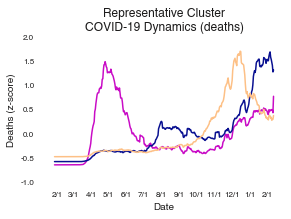

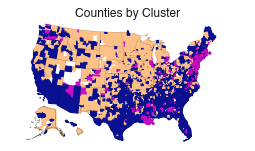

In [107]:
## Clustering plots

# Plot first day of the month
months = ["2/1/20", "3/1/20","4/1/20", "5/1/20", "6/1/20", "7/1/20", 
          "8/1/20", "9/1/20", "10/1/20", "11/1/20", "12/1/20", "1/1/21", "2/1/21"]
idxs = [list(all_dates).index(q) for q in months]
months = [q[:-3] for q in months]

## Plot cluster center
# Read in centers as determined by clustering.ipynb
centers = pd.read_csv("../data/centers.csv")
# Start plot
fig = plt.figure(figsize=set_size(312))
ax = fig.add_subplot(111)
for i in range(len(centers)):
    ax.plot(centers.iloc[[i]][all_dates].values.T, color=cluster_colors[i])
ax.set_xticks(idxs)
ax.set_xticklabels(months, fontproperties=prop, fontsize=8)
ax.set_xlabel("Date", fontproperties=prop, fontsize=10)
ys = ax.get_yticks()
ax.set_yticks(ys)
ax.set_yticklabels([round(q, 1) for q in ys], fontproperties=prop, fontsize=8)
ax.set_ylabel("Deaths (z-score)", fontproperties=prop, fontsize=10)
ax.set_title("Representative Cluster\nCOVID-19 Dynamics (deaths)", fontproperties=prop, fontsize=12)
sns.despine(left=True, bottom=True, top=True, right=True)
plt.savefig("../figures/chapter_3/figure_3_4/centers.svg", bbox_inches='tight', dpi=150)
plt.show()

## Now a map of the cluster centers
fig = plt.figure(figsize=set_size(312))
ax_map = fig.add_subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-98.58, central_latitude=39.83))
phase_vec = [cluster_colors[q] for q in df.cluster.values]
plot_vector_on_map(f, ax_map, phase_vec, 'Cluster Assignments', df, categorical=True)
ax_map.set_title("Counties by Cluster", fontproperties=prop, fontsize=12)
plt.savefig("../figures/chapter_3/figure_3_4/center_map.svg", bbox_inches='tight', dpi=150)
plt.show()


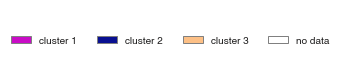

In [113]:
# Separate legend for the above plot
fig = plt.figure(figsize=(2, 1.25))
labels = ['cluster 1', 'cluster 2', 'cluster 3', 'no data']
cs = cluster_colors + ['white']
patches = [
    mpl.patches.Patch(facecolor=c, label=l, edgecolor='gray')
    for l, c in zip(labels, cs)]
plt.plot() # Empty plot
plt.xticks([])
plt.yticks([])
prop.set_size(10)
fig.legend(patches, labels, loc='center', frameon=False, prop=prop, ncol=4)
sns.despine(top=True, bottom=True, left=True, right=True)
plt.savefig('../figures/chapter_3/figure_3_4/cluster_legend.svg', bbox_inches='tight')
plt.show()

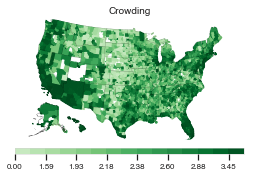

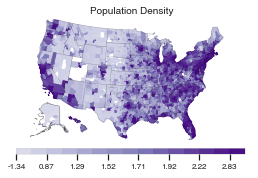

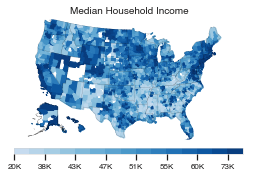

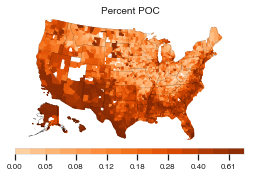

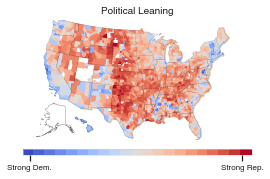

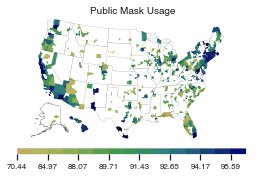

In [108]:
## Now, plot the continuous variables

# Variables to plot
indp_vars = ['crowding', 'pop_density', 'median_household_income', 'per_poc', 'political_leaning', 
              'public_mask_usage_p3']
# Plotted title
var_to_string = {'median_household_income':'Median Household Income', 'per_poc':'Percent POC', 
                 'political_leaning':'Political Leaning', 'pop_density':'Population Density', 'crowding':'Crowding', 
                'public_mask_usage_p3':'Public Mask Usage'}

# Plot each variable
for i, m in enumerate(indp_vars):
    fig = plt.figure(figsize=set_size(312))
    ax_map = fig.add_subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=37))
    vec = df[m].values
    
    # Take log of population density and crowding
    if m == 'pop_density' or m == 'crowding':
        vec = np.log10(vec+0.01)
        if m == 'crowding':
            vec[vec<0] = 0
    
    # Plot map
    plot_vector_on_map(fig, ax_map, vec, m, df, categorical=False, colorbar=True)
    ax_map.set_title(var_to_string[m], fontproperties=prop, size=10)
    plt.savefig("../figures/chapter_3/figure_3_4/%s.svg"%(m), bbox_inches='tight', dpi=300)
    plt.show()

#### Death rate plots as in Figure 3.10

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


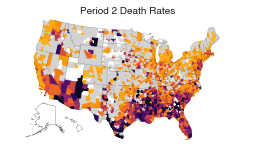

/mnt/c/Users/Justin Kaashoek/Documents/Senior/91r/env/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


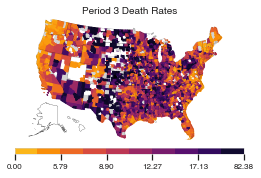

In [110]:
# Variables to plot
indp_vars = ['rate_2', 'rate_3']

# Plotted title
var_to_string = {'rate_2':'Period 2 Death Rates', 'rate_3':'Period 3 Death Rates'}

# Scale vector to be between 0 and 1
vec = reg_df['rate_3'].values
small, large = np.nanmin(vec), np.nanmax(vec)
vec = (vec - small) / (large-small)

# We're going to use preset limits based on rate_3 so that the plots have the same colors
buckets = np.unique(pd.qcut(vec, q=10).astype(str))
buckets = buckets[buckets != 'nan']

# Sort and ensure that the limits include 0 and 1
lims =  np.sort([float(q[1:q.find(',')]) for q in buckets])
lims[0] = 0
lims = np.append(lims,1)

# Plot each variable
for i, m in enumerate(indp_vars):
    fig = plt.figure(figsize=set_size(312))
    ax_map = fig.add_subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=37))
    vec = reg_df[m].values
    vec[vec < 0] = np.nan
    
    # Plot map
    plot_vector_on_map(fig, ax_map, vec, m, reg_df, categorical=False, colorbar=(m=='rate_3'), preset_lims=lims)
    ax_map.set_title(var_to_string[m], fontproperties=prop, size=10)
    plt.savefig("../figures/chapter_3/figure_3_10/%s.svg"%(m), bbox_inches='tight', dpi=300)
    plt.show()